W tym projekcie skupię się na zagadnieniu klasyfikacji. Posłuży mi do tego baza danych, którą zbudowałem poprzez scrapping danych z RapidAPI (API-FOOTBALL: https://rapidapi.com/api-sports/api/api-football/). Baza ta skupia zawodników z pięciu największych lig europejskich: Premier League (Anglia), Serie A (Włochy), Bundesligi (Niemcy), Ligue 1 (Francja) oraz La Liga (Hiszpania) i ich statystyki meczowe za sezon 2020/21. W pierwszej części dokonam klasyfikacji binarnej na napastników i graczy z pozostałych pozycji, w drugiej - postaram się dokonać klasyfikacji wszystkich zawodników wg ich pozycji.

# Import bibliotek.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from yellowbrick.target import class_balance
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time
from imblearn.ensemble import RUSBoostClassifier, EasyEnsembleClassifier, BalancedBaggingClassifier, BalancedRandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

# Załadowanie przygotowanej bazy danych.

In [2]:
def load_dataset(filename, index_col=None):
    dataset = pd.read_csv(f'{filename}', index_col=index_col)
    pd.options.display.max_columns = None
    return dataset

url = 'https://raw.githubusercontent.com/jakubtwalczak/Players_classification_20_21/main/Top5leagues.csv'

df = load_dataset(filename=url)
df

,Name,Age,Height,Weight,Position,Apps,Total minutes,Scored goals,Assists,Total shots,Shots on goal,Duels total,Duels won,Dribble attempts,Dribbles succ.,Total duels,Total passes,Key passes,Tackles,Blocks,Interceptions,Total saves,Goals conceded,Fouls drawn,Fouls committed,Yellow cards,Red cards for 2nd yellow,Straight red cards,Penalties won,Penalties scored,Penalties missed,Penalties committed,Penalties saved
0,S. Agüero,33,173 cm,70 kg,Attacker,12.0,559.0,4.0,1.0,17.0,12.0,51.0,21.0,13.0,8.0,51.0,171.0,7.0,4.0,NaN,2.0,NaN,0.0,7.0,2.0,0.0,0.0,0.0,NaN,1.0,1.0,NaN,NaN
1,Lee Grant,39,193 cm,83 kg,Goalkeeper,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0
2,B. Ivanović,37,185 cm,89 kg,Defender,13.0,765.0,0.0,NaN,3.0,1.0,58.0,31.0,NaN,NaN,58.0,317.0,1.0,14.0,5.0,8.0,NaN,0.0,4.0,11.0,2.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
3,Gary Cahill,37,193 cm,86 kg,Defender,20.0,1800.0,1.0,1.0,8.0,3.0,139.0,86.0,1.0,1.0,139.0,746.0,8.0,13.0,22.0,13.0,NaN,0.0,3.0,12.0,3.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
4,G. Sigurðsson,33,186 cm,79 kg,Midfielder,36.0,2255.0,6.0,5.0,33.0,17.0,169.0,67.0,26.0,14.0,169.0,853.0,44.0,30.0,2.0,34.0,NaN,0.0,18.0,22.0,2.0,0.0,0.0,NaN,3.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3696,Y. Muto,30,179 cm,72 kg,Midfielder,12.0,539.0,0.0,NaN,5.0,2.0,93.0,40.0,23.0,15.0,93.0,106.0,2.0,8.0,NaN,4.0,NaN,0.0,9.0,6.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
3697,Óscar Esaú Duarte Gaitán,33,186 cm,81 kg,Attacker,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN
3698,J. Calleri,29,181 cm,72 kg,Goalkeeper,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,1.0
3699,J. Guidetti,30,185 cm,79 kg,Goalkeeper,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,NaN,0.0


Już w pierwszych kolumnach uwidacznia się, że baza zawiera znaczną liczbę rekordów NaN, które trzeba w odpowiedni sposób wypełnić. Sprawdźmy więc liczbę nie-NaN-ów w poszczególnych kolumnach za pomocą funkcji pandas.DataFrame.info:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3701 entries, 0 to 3700
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Name                      3701 non-null   object 
 1   Age                       3701 non-null   int64  
 2   Height                    3391 non-null   object 
 3   Weight                    3162 non-null   object 
 4   Position                  3701 non-null   object 
 5   Apps                      3685 non-null   float64
 6   Total minutes             3685 non-null   float64
 7   Scored goals              3685 non-null   float64
 8   Assists                   1246 non-null   float64
 9   Total shots               2234 non-null   float64
 10  Shots on goal             1964 non-null   float64
 11  Duels total               2696 non-null   float64
 12  Duels won                 2624 non-null   float64
 13  Dribble attempts          2342 non-null   float64
 14  Dribbles

Okazuje się, że liczba NaN-ów jest znaczna, w niektórych kolumnach stanowi nawet niemal wszystkie rekordy. Co więcej, kolumny "Height" i "Weight" zawierają dane typu string (object), ze względu na dodanie na końcu każdego rekordu jednostki miary.

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,3701.0,26.643340,4.988452,17.0,22.0,26.0,30.00,50.0
Apps,3685.0,14.350068,13.127956,0.0,0.0,13.0,27.00,38.0
Total minutes,3685.0,952.512619,1021.158726,0.0,0.0,559.0,1764.00,3420.0
Scored goals,3685.0,1.305563,3.020377,0.0,0.0,0.0,1.00,41.0
Assists,1246.0,2.674157,2.272537,1.0,1.0,2.0,3.00,18.0
Total shots,2234.0,14.300806,15.904184,0.0,4.0,9.0,19.00,141.0
Shots on goal,1964.0,7.586049,9.082361,0.0,2.0,4.0,10.00,91.0
Duels total,2696.0,138.903190,118.242846,0.0,31.0,120.0,221.00,692.0
Duels won,2624.0,71.331174,60.467808,0.0,19.0,61.0,111.00,379.0
Dribble attempts,2342.0,24.549957,27.814035,0.0,5.0,15.0,33.00,247.0


Powyższe obserwacje potwierdzają również podstawowe statystyki opisowe. Zwróćmy też uwagę, iż dla znacznej części kolumn, w tym kolumny "Apps" przedstawiającej liczbę rozegranych meczów, pierwszy kwartyl przyjmuje wartość 0. Ponieważ chcemy klasyfikator oprzeć głównie na statystykach w poszczególnych elementach gry, trzeba będzie przyjąć pewien próg łącznie rozegranych minut, poniżej których nie klasyfikuję graczy. Tym progiem będzie 450 minut, czyli pięć pełnych rozegranych meczów.

In [5]:
df.columns

Index(['Name', 'Age', 'Height', 'Weight', 'Position', 'Apps', 'Total minutes',
       'Scored goals', 'Assists', 'Total shots', 'Shots on goal',
       'Duels total', 'Duels won', 'Dribble attempts', 'Dribbles succ.',
       'Total duels', 'Total passes', 'Key passes', 'Tackles', 'Blocks',
       'Interceptions', 'Total saves', 'Goals conceded', 'Fouls drawn',
       'Fouls committed', 'Yellow cards', 'Red cards for 2nd yellow',
       'Straight red cards', 'Penalties won', 'Penalties scored',
       'Penalties missed', 'Penalties committed', 'Penalties saved'],
      dtype='object')

Przystępujemy do "obróbki" bazy danych. Zacznijmy od przekształcenia danych w kolumnach "Height" i "Weight" na wartości liczbowe typu float poprzez usunięcie jednostki miary i rzutowanie wyniku.

In [6]:
df['Height'] =  df['Height'].str.replace("\D", "", regex = True).astype(float)
df['Weight'] = df['Weight'].str.replace("\D", "", regex = True).astype(float)

In [7]:
df.isnull().any()

Name                        False
Age                         False
Height                       True
Weight                       True
Position                    False
Apps                         True
Total minutes                True
Scored goals                 True
Assists                      True
Total shots                  True
Shots on goal                True
Duels total                  True
Duels won                    True
Dribble attempts             True
Dribbles succ.               True
Total duels                  True
Total passes                 True
Key passes                   True
Tackles                      True
Blocks                       True
Interceptions                True
Total saves                  True
Goals conceded               True
Fouls drawn                  True
Fouls committed              True
Yellow cards                 True
Red cards for 2nd yellow     True
Straight red cards           True
Penalties won                True
Penalties scor

Na potrzeby likwidacji wartości NaN przyjmę następującą konwencję:
- wartości w kolumnach dot. statystyk meczowych zastępować będę zerem,
- wartości w kolumnach dot. wzrostu i wagi zastąpię medianą z tych kolumn. 

Da się bowiem przyjąć, że piłkarz może nie zanotować osiągów w jakimś elemencie gry, ale przyjęcie wzrostu lub wagi na poziomie 0 może prowadzić do karykaturalnych wyników.

In [8]:
df['Weight'].fillna((df['Weight'].median()), inplace=True)
df['Height'].fillna((df['Height'].median()), inplace=True)

In [9]:
df.fillna(0, inplace=True)

Usuwam kolumnę "Name" (bo nazwiska piłkarzy nam się do niczego nie przydadzą) i "Duels total" (bo została błędnie dodana jako duplikat kolumny "Total duels" przy budowaniu bazy).

In [10]:
df.drop(columns=['Name', 'Duels total'], axis = 1, inplace=True)

Zgodnie z przyjętym wyżej progiem, usuwam zawodników poniżej 450 rozegranych minut.

In [11]:
df = df[df['Total minutes']>=450]

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 0 to 3696
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       1946 non-null   int64  
 1   Height                    1946 non-null   float64
 2   Weight                    1946 non-null   float64
 3   Position                  1946 non-null   object 
 4   Apps                      1946 non-null   float64
 5   Total minutes             1946 non-null   float64
 6   Scored goals              1946 non-null   float64
 7   Assists                   1946 non-null   float64
 8   Total shots               1946 non-null   float64
 9   Shots on goal             1946 non-null   float64
 10  Duels won                 1946 non-null   float64
 11  Dribble attempts          1946 non-null   float64
 12  Dribbles succ.            1946 non-null   float64
 13  Total duels               1946 non-null   float64
 14  Total pa

W ten sposób pozbyliśmy się NaN-ów oraz zbędnych kolumn tekstowych, baza danych jest zatem przygotowana do tworzenia modeli. Zgodnie z założeniami jedyną kolumną tekstową jest kolumna "Position", która służyć nam będzie do klasyfikacji graczy.

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1946.0,26.822199,4.900054,17.0,23.00,26.0,30.0,50.0
Height,1946.0,182.490236,6.548860,156.0,178.00,183.0,187.0,202.0
Weight,1946.0,75.963515,6.814939,55.0,72.00,76.0,80.0,100.0
Apps,1946.0,25.189106,8.003932,5.0,19.00,26.0,32.0,38.0
Total minutes,1946.0,1742.741007,799.427329,450.0,1080.00,1683.0,2399.0,3420.0
Scored goals,1946.0,2.411614,3.821015,0.0,0.00,1.0,3.0,41.0
Assists,1946.0,1.645940,2.250285,0.0,0.00,1.0,2.0,18.0
Total shots,1946.0,15.519013,16.439400,0.0,4.00,11.0,21.0,141.0
Shots on goal,1946.0,7.262076,9.185334,0.0,1.00,4.0,10.0,91.0
Duels won,1946.0,91.139774,57.250543,0.0,47.00,83.5,128.0,379.0


Sprawdzamy rozkład zmiennych kategoryzujących dot. pozycji. Zdecydowanie najliczniejsi (i bardzo zbliżeni pod względem liczebności) są obrońcy i pomocnicy, o ok. 1/3 mniej jest napastników, a zdecydowanie najmniejszą grupę stanowią bramkarze (circa sześciokrotnie mniej liczną niż pomocnicy czy obrońcy).

In [14]:
df.Position.value_counts(dropna=False, normalize=True)

Defender      0.371017
Midfielder    0.344296
Attacker      0.216855
Goalkeeper    0.067831
Name: Position, dtype: float64

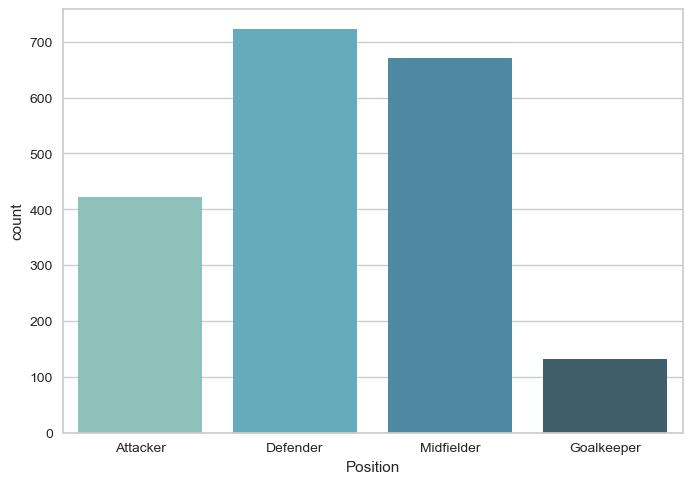

In [15]:
sns.countplot(x='Position',data=df, palette='GnBu_d')
plt.show()

Sprawdźmy teraz statystyki opisowe dla każdej z pozycji, w czym pomoże nam tabela piwotalna.

Separowalność klas dobrze sprawdzić w kolumnach dot. średnich wartości. Najlepiej pod tym względem sprawdzają się zmienne dot. statystyk typowych dla graczy ofensywnych ("Dribble attempts", "Dribble succ.", "Scored goals", "Shots on goal", "Total shots") czy stricte defensywnych ("Blocks", "Interceptions") oraz zmienna dot. całkowitej liczby podań ("Total passes"). 

Statystyki pomocników, z uwagi na swoistą "pośredniość" ustawienia na boisku, bywają zbliżone bądź to do napastników (np. "Assists", "Key passes") bądź obrońców (m.in. "Yellow cards", "Tackles"), bądź jednych i drugich (np. "Duels won"). 

Praktycznie każda kolumna zapewnia separowalność bramkarzy od zawodników z pozostałych pozycji. Kolumny "Apps", "Height", "Weight" nie pozwalają z kolei na dostateczny podział wg etykiet.

In [16]:
pivot = pd.pivot_table(df, index='Position', values = ['Height', 'Weight','Apps', 'Total minutes',
       'Scored goals', 'Assists', 'Total shots', 'Shots on goal',
       'Duels won', 'Dribble attempts', 'Dribbles succ.',
       'Total duels', 'Total passes', 'Key passes', 'Tackles', 'Blocks',
       'Interceptions', 'Total saves', 'Goals conceded', 'Fouls drawn',
       'Fouls committed', 'Yellow cards', 'Red cards for 2nd yellow',
       'Straight red cards', 'Penalties won', 'Penalties scored',
       'Penalties missed', 'Penalties committed', 'Penalties saved'], aggfunc= [np.mean, np.median, min, max, np.std])
pd.options.display.max_columns = None
display(pivot)

mean                                                      \
                 Apps   Assists    Blocks Dribble attempts Dribbles succ.   
Position                                                                    
Attacker    26.898104  2.646919  1.213270        45.078199      24.568720   
Defender    23.321330  0.969529  9.565097        16.693906      10.134349   
Goalkeeper  25.727273  0.053030  0.000000         0.462121       0.439394   
Midfielder  26.019403  2.058209  3.694030        34.349254      21.032836   

                                                                              \
            Duels won Fouls committed Fouls drawn Goals conceded      Height   
Position                                                                       
Attacker    99.563981       23.357820   28.462085       0.000000  181.971564   
Defender    93.149584       21.051247   15.753463       0.000000  182.375346   
Goalkeeper   9.530303        0.568182    3.000000      35.083333  183.318182   
Midfielder  99.746269       26.092537   24.895522       0.000000  182.777612   

                                                                          \
           Interceptions Key passes Penalties committed Penalties missed   
Position                                                                   
Attacker        7.755924  21.424171            0.000000         0.184834   
Defender       29.132964  10.148199            0.006925         0.002770   
Goalkeeper      0.818182   0.424242            0.000000         0.007576   
Midfielder     21.562687  20.737313            0.000000         0.065672   

                                                           \
           Penalties saved Penalties scored Penalties won   
Position                                                    
Attacker          0.000000         0.767773      0.004739   
Defender          0.000000         0.024931      0.002770   
Goalkeeper        0.863636         0.007576      0.000000   
Midfielder        0.000000         0.276119      0.000000   

                                                                \
           Red cards for 2nd yellow Scored goals Shots on goal   
Position                                                         
Attacker                   0.037915     6.215640     16.855450   
Defender                   0.087258     0.880886      2.997230   
Goalkeeper                 0.000000     0.015152      0.030303   
Midfielder                 0.064179     2.137313      7.240299   

                                                                    \
           Straight red cards    Tackles Total duels Total minutes   
Position                                                             
Attacker             0.068720  15.654028  224.063981   1587.864929   
Defender             0.103878  31.504155  167.006925   1784.948753   
Goalkeeper           0.075758   0.628788   11.659091   2301.946970   
Midfielder           0.091045  33.798507  203.700000   1684.634328   

                                                                         \
           Total passes Total saves Total shots     Weight Yellow cards   
Position                                                                  
Attacker     468.597156    0.000000   31.872038  75.227488     2.407583   
Defender     974.988920    0.000000    8.060942  75.944598     3.743767   
Goalkeeper   739.742424   70.856061    0.068182  76.325758     0.992424   
Midfielder   855.580597    0.000000   16.300000  76.376119     3.911940   

           median                                                           \
             Apps Assists Blocks Dribble attempts Dribbles succ. Duels won   
Position                                                                     
Attacker     28.0     2.0    1.0             33.5           18.0      92.0   
Defender     24.0     0.0    7.0             11.0            7.0      86.0   
Goalkeeper   30.0     0.0    0.0              0.0            0.0       9.0   
Midfiel

Heatmap wskazuje wyraźnie, iż znaczna część zmiennych pozostaje w wysokiej korelacji dodatniej. Ta współliniowość wskazuje na potrzebę znalezienia niskowymiarowej reprezentacji danych.

<AxesSubplot:>

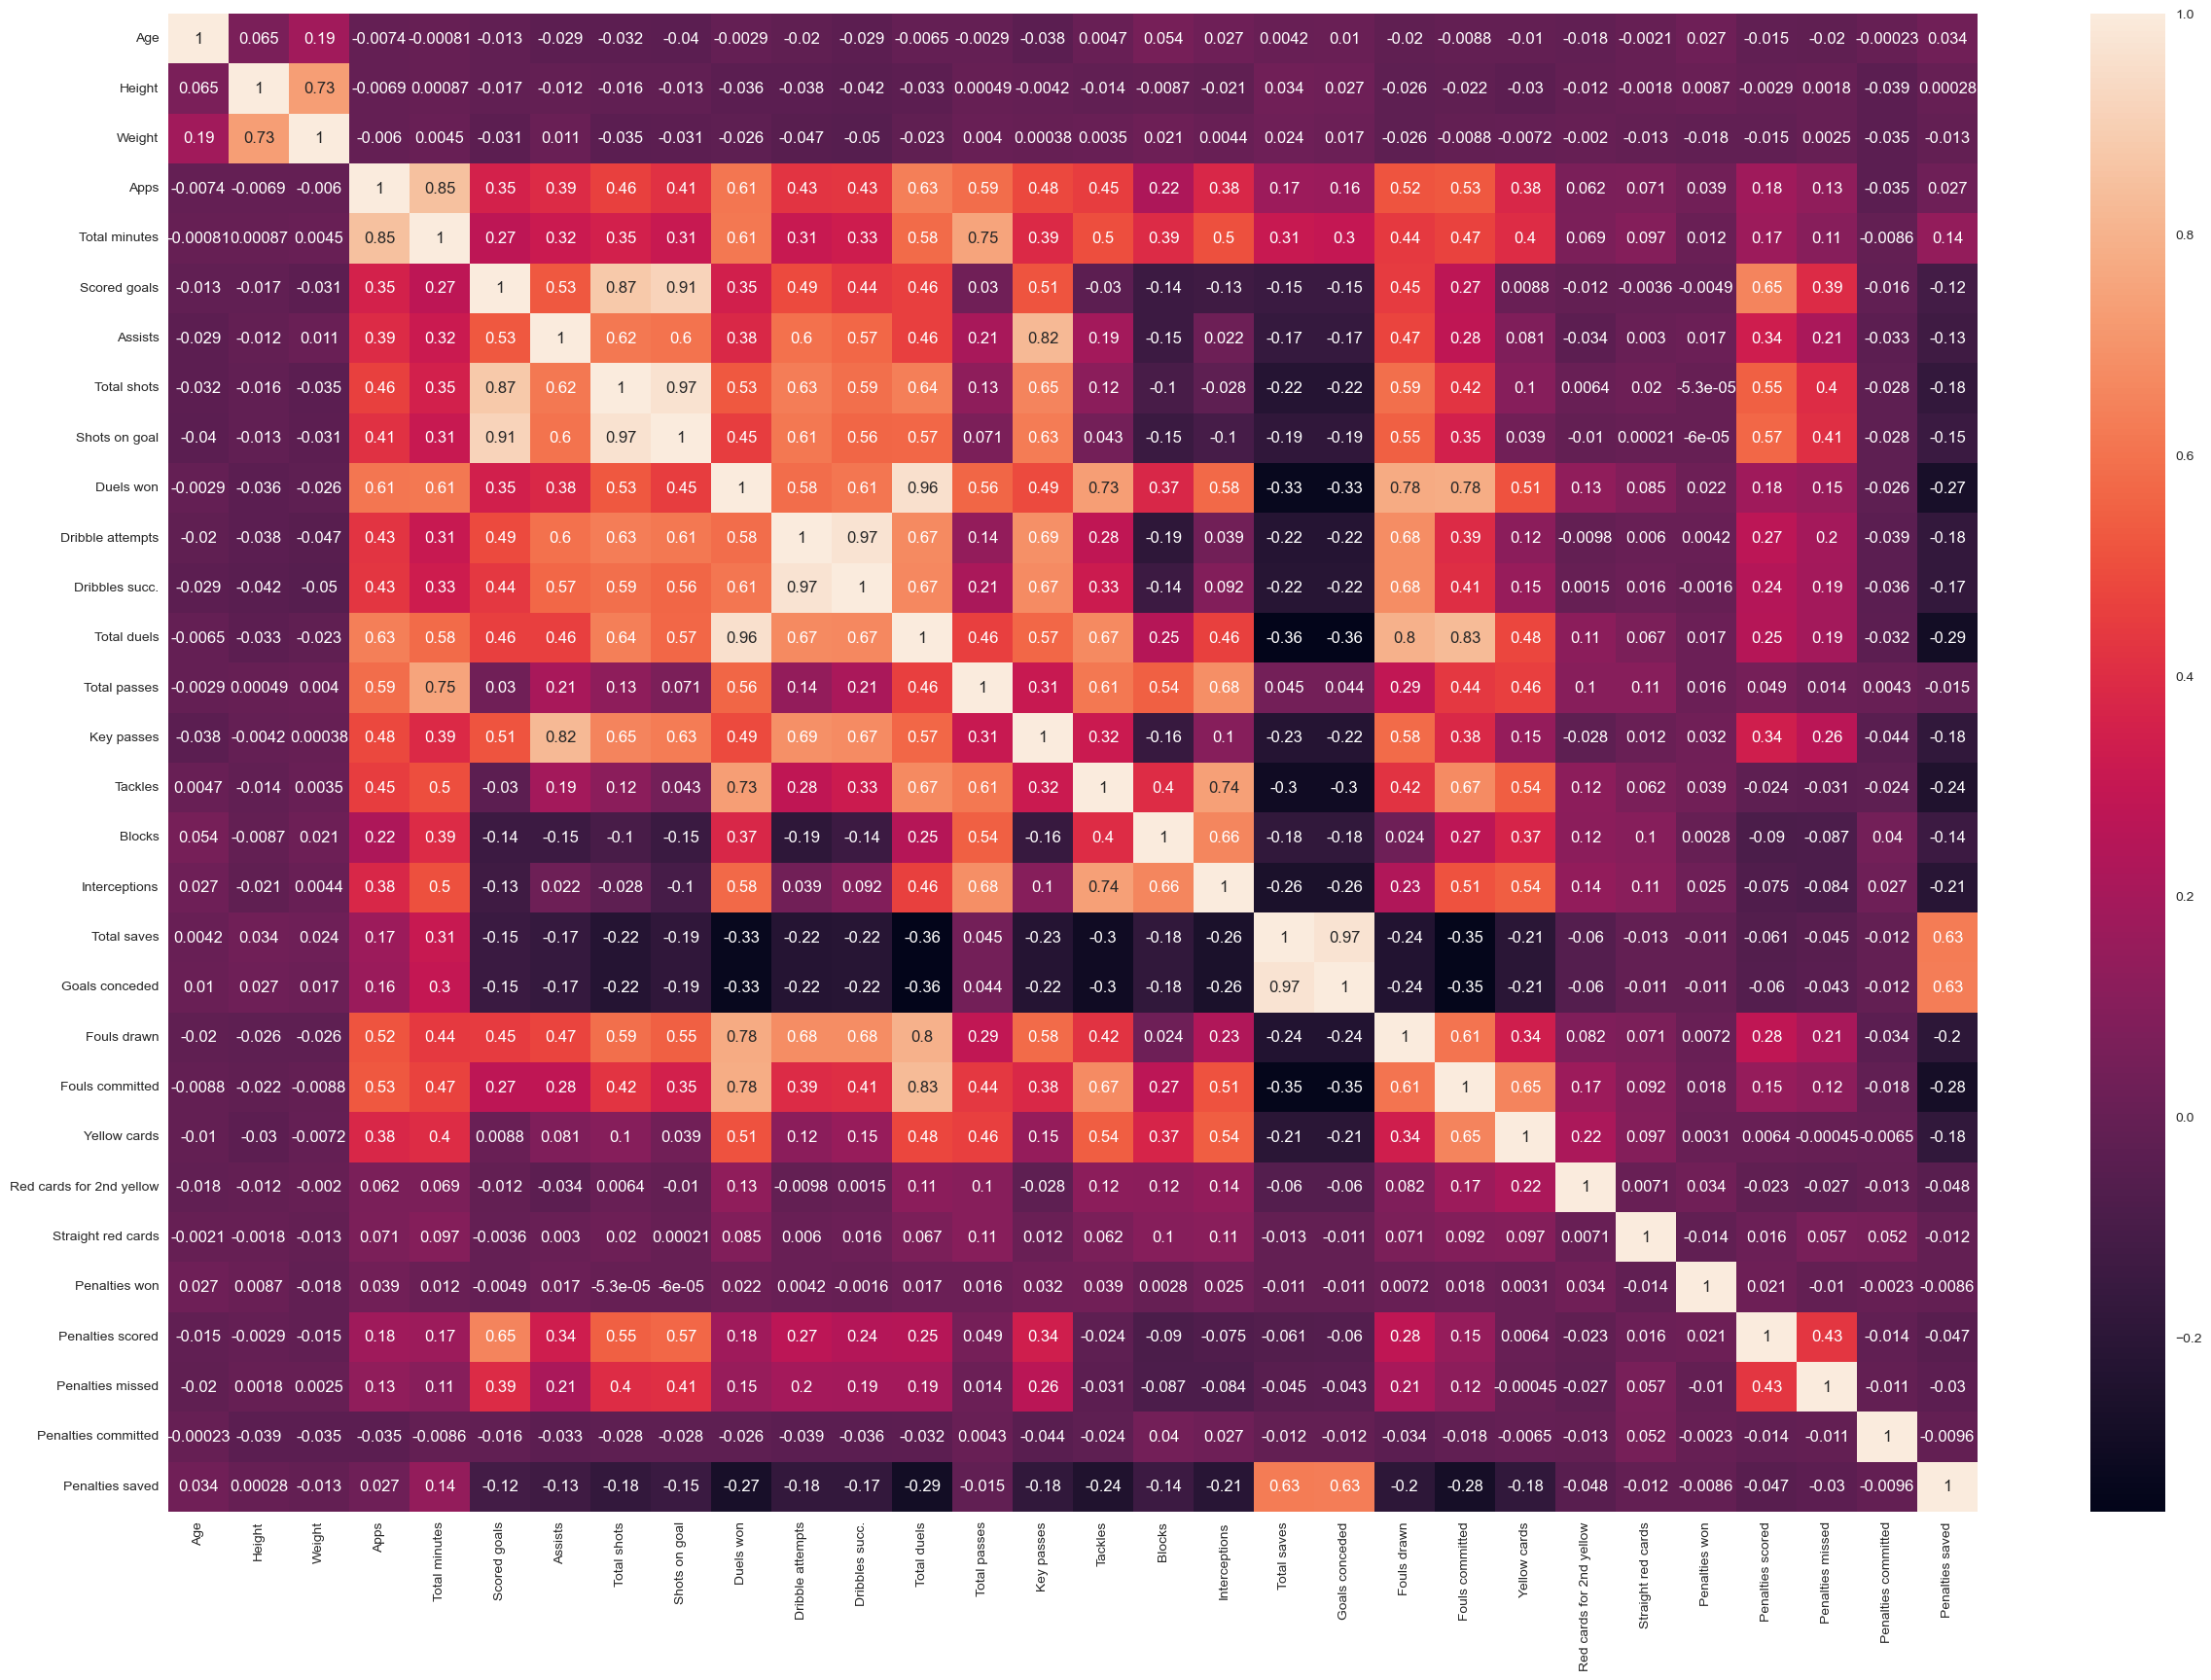

In [17]:
cm = df.corr()
fig, ax = plt.subplots(figsize=(30,20))
sns.heatmap(cm, annot=True)

# Napastnicy wśród zawodników z innych pozycji - klasyfikacja binarna.

## Przygotowanie i podział zbiorów, redukcja wymiarów.

Naturalnie rozpocząć powinniśmy od zdefiniowania zbiorów X: zmiennych zależnych (dotyczących statystyk meczowych) i Y: etykiet (pozycji graczy). Zbiory stworzymy bardzo prosto: X - poprzez usunięcie kolumny "Position", Y - poprzez wyodrębnienie kolumny "Position", a następnie poprzez przypisanie tychże do tak nazwanych zmiennych.

In [18]:
X = df.drop(columns='Position')
Y = df['Position']

In [19]:
print(X.head())

   Age  Height  Weight  Apps  Total minutes  Scored goals  Assists  \
0   33   173.0    70.0  12.0          559.0           4.0      1.0   
2   37   185.0    89.0  13.0          765.0           0.0      0.0   
3   37   193.0    86.0  20.0         1800.0           1.0      1.0   
4   33   186.0    79.0  36.0         2255.0           6.0      5.0   
6   35   180.0    70.0  21.0          705.0           0.0      0.0   

   Total shots  Shots on goal  Duels won  Dribble attempts  Dribbles succ.  \
0         17.0           12.0       21.0              13.0             8.0   
2          3.0            1.0       31.0               0.0             0.0   
3          8.0            3.0       86.0               1.0             1.0   
4         33.0           17.0       67.0              26.0            14.0   
6          1.0            0.0       21.0               2.0             2.0   

   Total duels  Total passes  Key passes  Tackles  Blocks  Interceptions  \
0         51.0         171.0      

In [20]:
Y

0         Attacker
2         Defender
3         Defender
4       Midfielder
6       Midfielder
           ...    
3692      Defender
3693      Defender
3694    Midfielder
3695      Defender
3696    Midfielder
Name: Position, Length: 1946, dtype: object

Na zbiorze Y wykonamy prosty encoding przy pomocy funkcji numpy.where - rekordy dot. napastników zmienimy na 1, dot. innych pozycji - na 0.

In [21]:
y = np.where(Y == 'Attacker', 1, 0)

In [22]:
y

array([1, 0, 0, ..., 0, 0, 0])

Sprawdźmy teraz, jak rozkładają się zadane klasy.

In [23]:
np.unique(y, return_counts=True)

(array([0, 1]), array([1524,  422], dtype=int64))

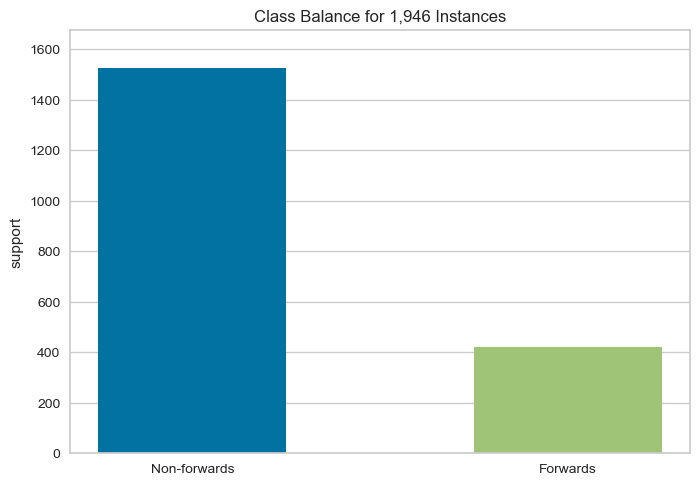

ClassBalance(ax=<AxesSubplot:title={'center':'Class Balance for 1,946 Instances'}, ylabel='support'>,
             labels=['Non-forwards', 'Forwards'])

In [24]:
class_balance(y.flatten(), labels=['Non-forwards', 'Forwards'])

Train test splitem dokonamy podziału na zbiór treningowy (70% rekordów) i testowy (30%). Parametr stratify o wartości y pozwoli na zachowanie równego stosunku liczebności klas w obu zbiorach.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.3,
                                                    random_state = 42,
                                                    stratify=y)

In [26]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1]), array([1067,  295], dtype=int64))
(array([0, 1]), array([457, 127], dtype=int64))


### PCA.

Baza danych, na której pracujemy, zawiera dużą liczbę zmiennych numerycznych (30), w znacznym stopniu skorelowanych. Aby zredukować liczbę zmiennych i korelacji, przydatnym narzędziem będzie PCA - Principal Component Analysis.

Operację z użyciem PCA dokonać należy na danych już zestandaryzowanych. Poszczególne cechy prezentują bowiem różny rząd wysokości, a pożądanym będzie zachowanie równoważności cech.

Text(0, 0.5, 'variance')

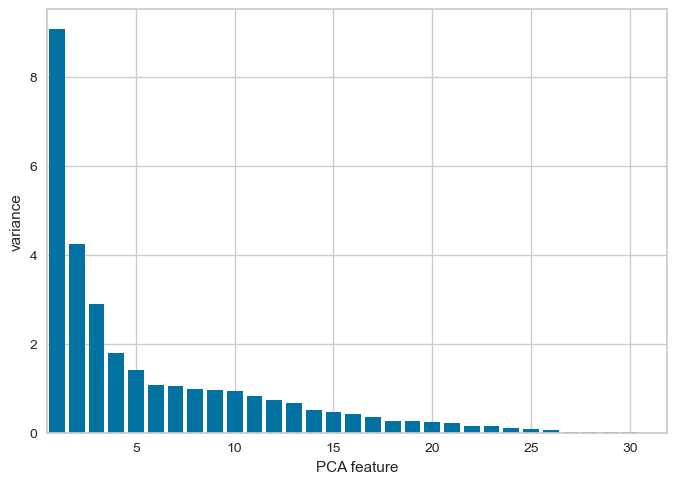

In [27]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

pca = PCA()

X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

features = range(1, pca.n_components_+1)
plt.bar(features, pca.explained_variance_)
plt.xlim(xmin=0.5)
plt.xlabel('PCA feature')
plt.ylabel('variance')

Jak widać, wariancja gwałtownie spada już przy pierwszych 4 cechach. Bardzo wysokie wyjaśnienie wariancji ma jednak z kolei miejsce dopiero przy użyciu mniej więcej 10. cechy. Powyżej 20. cechy mamy już raczej do czynienia z szumem aniżeli wartościowymi predyktorami.

In [28]:
pca.explained_variance_ratio_

array([0.30206072, 0.14108147, 0.09660369, 0.05959996, 0.04720121,
       0.03562622, 0.0350946 , 0.03245157, 0.03173744, 0.03146522,
       0.02776658, 0.02414656, 0.02215142, 0.0172984 , 0.01520337,
       0.01428834, 0.01154914, 0.00899414, 0.00870079, 0.00805401,
       0.00726623, 0.00531958, 0.00481283, 0.00357449, 0.00307883,
       0.00213012, 0.00083544, 0.00081565, 0.00076292, 0.00032906])

Ponownie wytrenujmy zatem PCA, tym razem przy użyciu parametru n_components równego 14.

In [29]:
pca = PCA(n_components=14)

X_train_sc = pca.fit_transform(X_train_sc)
X_test_sc = pca.transform(X_test_sc)

print(X_train_sc.shape)

(1362, 14)


Text(0, 0.5, 'variance')

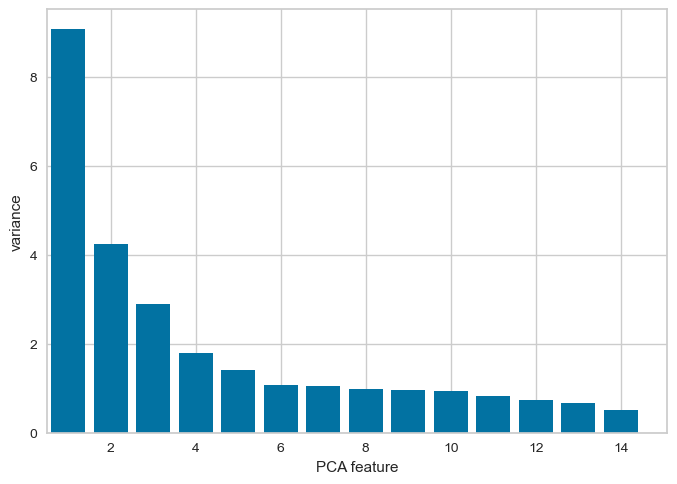

In [30]:
features = range(1, pca.n_components_+1)
plt.bar(features, pca.explained_variance_)
plt.xlim(xmin=0.5)
plt.xlabel('PCA feature')
plt.ylabel('variance')

Pierwszych 10 cech wyjaśnia ok. 90,4% całości wariancji. Taka liczba zmiennych w zupełności wystarczy do stworzenia modeli wystarczająco szybkich obliczeniowo, ale i względnie precyzyjnych.

In [31]:
np.sum(pca.explained_variance_ratio_)

0.9042850499085641

In [32]:
X_train_sc

array([[-1.68703   ,  0.64501156, -0.64978563, ...,  0.30896047,
         0.6196551 ,  0.36263179],
       [ 0.56647787,  2.25090008, -0.46191181, ..., -0.8682243 ,
         0.02816196, -0.56905795],
       [ 3.73737084,  0.50382176,  0.29714993, ...,  0.94572647,
        -0.77170133, -0.57487189],
       ...,
       [ 4.80243166,  1.66517311,  0.5586537 , ...,  0.87769505,
        -0.12968167, -0.49284783],
       [ 3.87528423,  4.3956356 ,  0.40386874, ..., -1.56240213,
         0.90653873, -2.65479691],
       [ 3.51123841,  3.25947746,  0.58042659, ...,  0.27061118,
         1.08004898,  0.03844398]])

In [33]:
X_test_sc

array([[11.37602528,  3.0166541 ,  0.87798535, ...,  0.64096661,
         2.74957066,  2.87121918],
       [ 6.51946377, -0.37848402,  0.5651873 , ..., -0.31499796,
        -0.74744264, -0.5580147 ],
       [-1.059039  ,  0.42526501, -0.75822457, ..., -1.00410258,
        -1.29526044, -0.47292655],
       ...,
       [-2.77700108,  1.33327494, -0.72910621, ..., -0.31638155,
        -0.4928426 , -0.710815  ],
       [-4.03489806,  0.47638477,  4.39221279, ..., -0.18834007,
         0.13240089, -0.91597654],
       [ 0.57102376, -0.57281782,  0.13681791, ...,  1.81137571,
         0.33163761, -1.78078506]])

## Modelowanie.

Problemem jest fakt sporego niezbalansowania danych. W przypadku klasyfikacji binarnej napastników mamy blisko cztery razy mniej niż nie-napastników. Z tego powodu najpierw przetestuję w niniejszym projekcie cztery klasyfikatory pochodzące z biblioteki Imbalanced-learn (Imblearn) i porównam ich rezultaty. Każdy z klasyfikatorów stosuje metodę losowego podpróbkowania (random oversampling) - usuwa on przykłady z klasy większościowej; może to niestety prowadzić do utraty istotnych dla modelu informacji. Dla porównania przetestuję również dwa algorytmy z biblioteki Scikit-learn (Sklearn), oparte na tej samej zasadzie działania, co sprawdzane klasyfikatory z Imblearna - mowa tu o AdaBoostClassifierze i Random Forest Classifierze - jednak zastosuję przy tym metody nadpróbkowania losowego (random oversampling) przy pomocy klasy SMOTE. Jest to algorytm, który wykorzystuje metodę k-najbliższych sąsiadów, żeby stworzyć syntetyczne próbki danych klasy mniejszościowej i w ten sposób wyrównać liczebność próbek w klasach.

Nie będę przy tym stosował dostrajania hiperparametrów modeli - pozwoli to na ich miarodajne porównanie, w tym czasu ich uczenia.

### Balanced Random Forest Classifier.

Pierwszym algorytmem, który będziemy poddawać treningowi, jest Balanced Random Forest Classifier, czyli odmiana scikit-learnowskiego Random Forest Classifiera dla zbiorów niezbalansowanych. Model ten buduje określoną liczbę drzew decyzyjnych (domyślnie 100 i taką ilość przyjmiemy jako stałą, gdyż w istocie wielkość lasu losowego ma większy wpływ na długość uczenia niźli na wyniki) na różnych podgrupach próbek danych i uśrednia wyniki, co pozwala na poprawę dokładności i przeciwdziałanie przeuczeniu. BalancedRFC nie wymaga do uczenia danych znormalizowanych.

In [34]:
brfc_model = BalancedRandomForestClassifier()

start = time.time()
brfc_model.fit(X_train_sc, y_train)
brfc_train_pred = brfc_model.predict(X_train_sc)
stop = time.time()
time_diff_brfc = stop - start
print(f"Training time: {time_diff_brfc} s.")

Training time: 0.5989947319030762 s.


Model okazał się bardzo dobry w wykrywaniu napastników w zbiorze treningowym (wykrytych 100% próbek), ale czułość spada w przypadku zbioru testowego na poziom 0,92. Jak można było się spodziewać, model nie jest zbytnio precyzyjny - F1 score w zbiorze testowym co do klasy pozytywnej wynosi raptem 0,78. Zrzucić to jednak można na karb zwrócenia większej uwagi na klasę pozytywną.

In [35]:
brfc_test_pred = brfc_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, brfc_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, brfc_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1067
           1       0.76      1.00      0.87       295

    accuracy                           0.93      1362
   macro avg       0.88      0.96      0.91      1362
weighted avg       0.95      0.93      0.94      1362

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.98      0.88      0.92       457
           1       0.68      0.92      0.78       127

    accuracy                           0.89       584
   macro avg       0.83      0.90      0.85       584
weighted avg       0.91      0.89      0.89       584



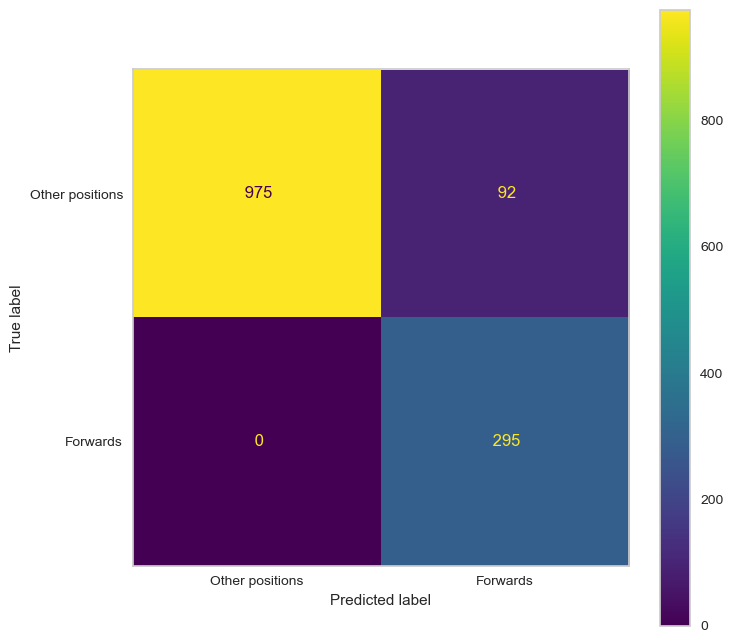

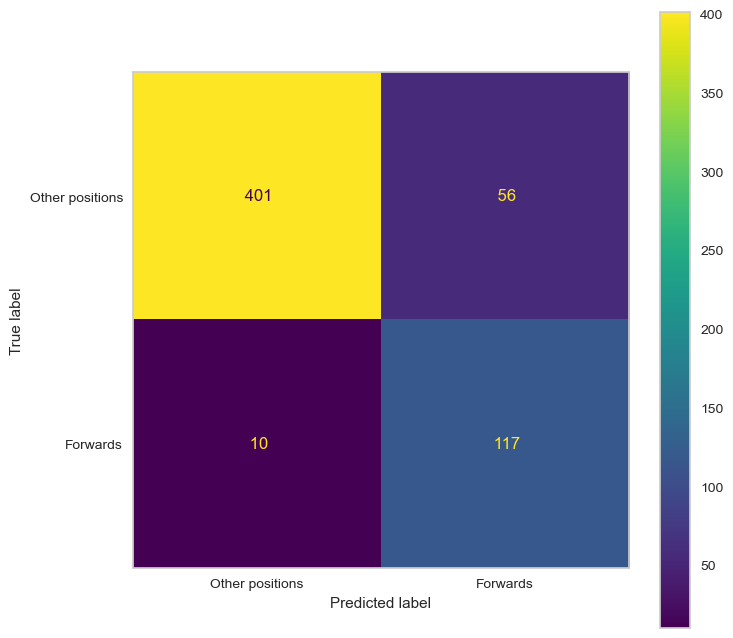

In [36]:
labels = ['Other positions', 'Forwards']

def conf_matrix_show(estimator, X, y, classes):
    fig, ax = plt.subplots(figsize=(8,8))
    cmd = ConfusionMatrixDisplay.from_estimator(estimator, X, y, display_labels=classes, ax=ax, values_format=' ')
    ax.grid(False)
    
conf_matrix_show(brfc_model, X_train_sc, y_train, labels)
conf_matrix_show(brfc_model, X_test_sc, y_test, labels)

Zbudujmy przy okazji listy metryk zbiorów (z uwagi na niezbalansowanie klas będzie nas najbardziej interesować precyzja i czułość) oraz czasów ich treningu, które rozszerzać będziemy przy testowaniu każdego modelu. Będzie to przydatne do podsumowania i porównania modeli.

In [37]:
train_recall = []
test_recall = []
train_precision = []
test_precision = []
time_diffs = []
train_recall.append(recall_score(y_train, brfc_train_pred))
test_recall.append(recall_score(y_test, brfc_test_pred))
train_precision.append(precision_score(y_train, brfc_train_pred))
test_precision.append(precision_score(y_test, brfc_test_pred))
time_diffs.append(time_diff_brfc)

### EasyEnsembleClassifier.

Klasyfikator ten jest również klasyfikatorem zespołowym, opartym na boostingu - to grupa określonej liczby klasyfikatorów AdaBoost wyuczonych na różnych zbalansowanych próbkach uzyskanych w drodze bootstrappingu. Co jest typowe dla boostingu, każdy kolejny estymator ma za zadanie poprawić błąd poprzedniego, gdyż zwraca uwagę na błędy popełniane przez poprzednika.

In [38]:
eec_model = EasyEnsembleClassifier()

start = time.time()
eec_model.fit(X_train_sc, y_train)
eec_train_pred = eec_model.predict(X_train_sc)
stop = time.time()
time_diff_eec = stop - start
print(f"Training time: {time_diff_eec} s")

Training time: 1.9025750160217285 s


Model uczył się blisko trzy razy dłużej niż Balanced RFC, ale jego zdolność do uogólniania jest wyższa. Czułość dla zbioru testowego wyniosła 0,94 przy precyzji 0,69.

In [39]:
eec_test_pred = eec_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, eec_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, eec_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1067
           1       0.75      0.99      0.85       295

    accuracy                           0.93      1362
   macro avg       0.87      0.95      0.90      1362
weighted avg       0.94      0.93      0.93      1362

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       457
           1       0.69      0.94      0.79       127

    accuracy                           0.89       584
   macro avg       0.83      0.91      0.86       584
weighted avg       0.92      0.89      0.90       584



Model przypisuje raptem ok. 12% przypadków negatywnych do klasy pozytywnej. Gdy weźmie się pod uwagę, że liczba false negatives jest znikoma, precyzja nieprzekraczająca 0,7 nie jest szczególnie niepokojąca.

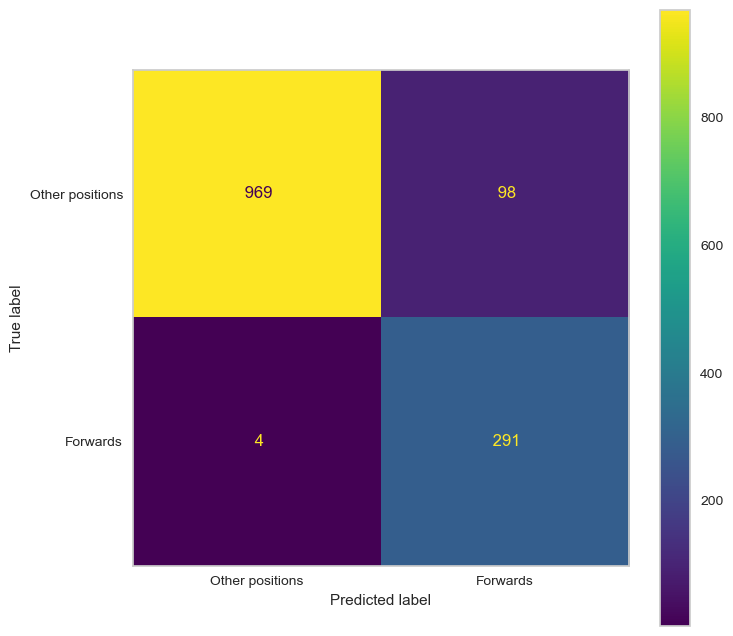

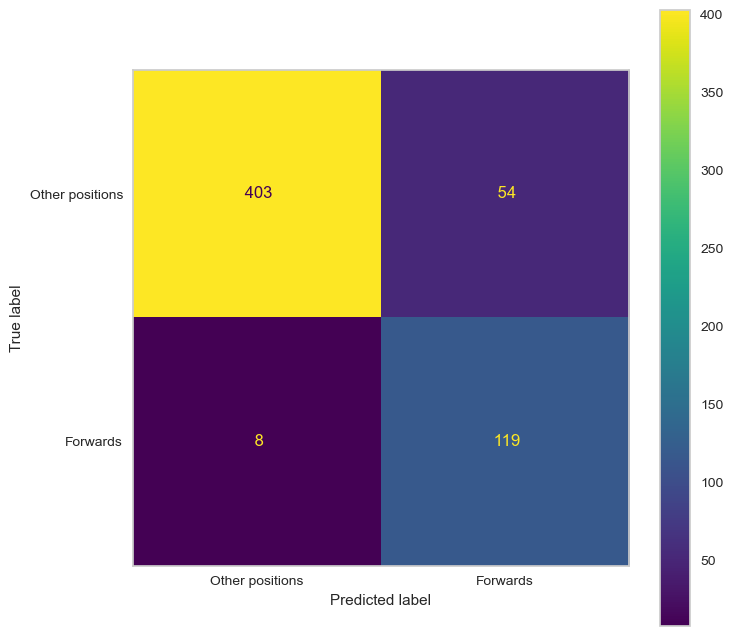

In [40]:
conf_matrix_show(eec_model, X_train_sc, y_train, labels)
conf_matrix_show(eec_model, X_test_sc, y_test, labels)

Oczywiście dopisujemy również nowe elementy do list służących porównaniu.

In [41]:
train_recall.append(recall_score(y_train, eec_train_pred))
test_recall.append(recall_score(y_test, eec_test_pred))
train_precision.append(precision_score(y_train, eec_train_pred))
test_precision.append(precision_score(y_test, eec_test_pred))
time_diffs.append(time_diff_eec)

### RUS Boost Classifier.

RUS (Random Under-Sampling) Boost Classifier również opiera się na boostingu. Różnica między nim a Easy Ensemble polega na tym, że o ile Easy Ensemble jest zespołem wielu klasyfikatorów boostingowych, o tyle RUS Boost jest pojedynczym klasyfikatorem boostingowym, zrzeszającym określoną liczbę drzew decyzyjnych.

In [42]:
rusbc_model = RUSBoostClassifier()

start = time.time()
rusbc_model.fit(X_train_sc, y_train)
rusbc_train_pred = rusbc_model.predict(X_train_sc)
stop = time.time()
time_diff_rusbc = stop - start
print(f"Training time: {time_diff_rusbc} s")

Training time: 0.1759965419769287 s


Model wyuczył się zdecydowanie najszybciej, ale i jego wyniki są nieco słabsze. Precyzja jest nawet nieco wyższa niż w przypadku Easy Ensemble, ale spory jest spadek true positives.

In [43]:
rusbc_test_pred = rusbc_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, rusbc_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rusbc_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.98      0.93      0.95      1067
           1       0.78      0.92      0.85       295

    accuracy                           0.93      1362
   macro avg       0.88      0.92      0.90      1362
weighted avg       0.93      0.93      0.93      1362

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       457
           1       0.69      0.84      0.76       127

    accuracy                           0.89       584
   macro avg       0.82      0.87      0.84       584
weighted avg       0.90      0.89      0.89       584



Nie może ujść uwadze to, że niniejszy algorytm jest pierwszym, który tak słabo wypada w klasyfikowaniu przypadków pozytywnych - te błędnie wykryte stanowią ok. 8% zbioru treningowego i niecałe 16% zbioru testowego.

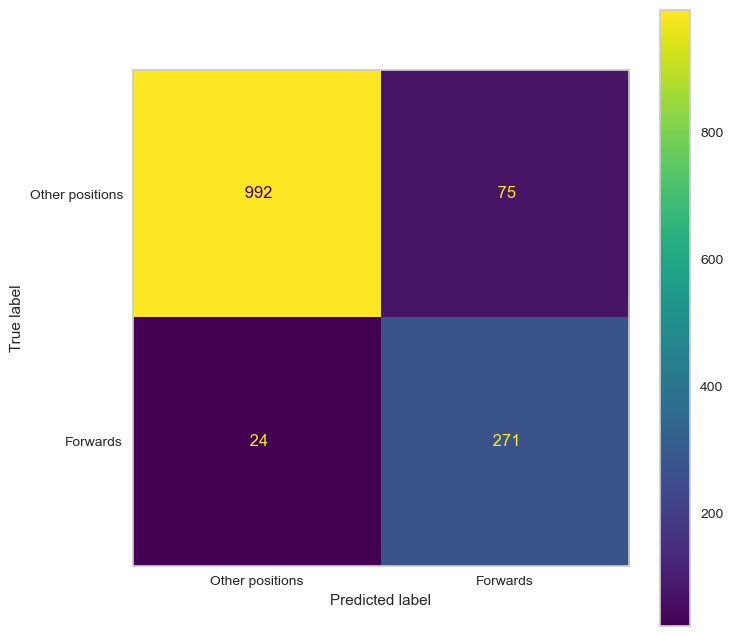

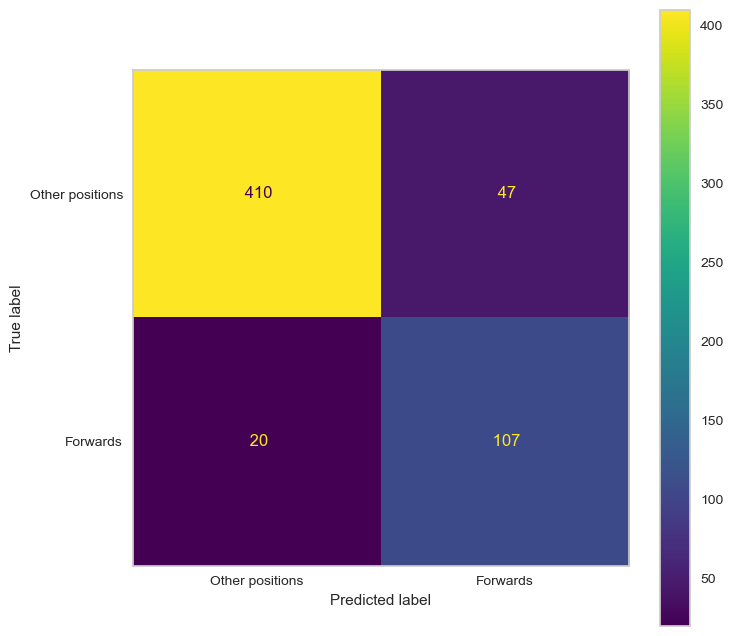

In [44]:
conf_matrix_show(rusbc_model, X_train_sc, y_train, labels)
conf_matrix_show(rusbc_model, X_test_sc, y_test, labels)

Dalej poszerzamy nasze listy o ww. wyniki.

In [45]:
train_recall.append(recall_score(y_train, rusbc_train_pred))
test_recall.append(recall_score(y_test, rusbc_test_pred))
train_precision.append(precision_score(y_train, rusbc_train_pred))
test_precision.append(precision_score(y_test, rusbc_test_pred))
time_diffs.append(time_diff_rusbc)

### Balanced Bagging Classifier.

Balanced Bagging Classifier stosuje, tak jak Balanced Random Forest, bagging - trenuje modele drzew decyzyjnych na zbalansowanych podzbiorach danych oryginalnych i agreguje (poprzez uśrednianie lub głosowanie) ich wyniki.

In [46]:
bbc_model = BalancedBaggingClassifier()

start = time.time()
bbc_model.fit(X_train_sc, y_train)
bbc_train_pred = bbc_model.predict(X_train_sc)
stop = time.time()
time_diff_bbc = stop - start
print(f"Training time: {time_diff_bbc} s")

Training time: 0.0669865608215332 s


Model uczy się bardzo szybko (0,08 s!) i ma bardzo obiecujące wyniki w zbiorze treningowym (czułość 1 co do klasy pozytywnej przy precyzji 0.83), ale gdy przychodzi do zbioru testowego, metryki wyraźnie spadają, nawet o kilkanaście setnych punktu w zakresie klasy napastników.

In [47]:
bbc_test_pred = bbc_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, bbc_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, bbc_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       1.00      0.94      0.97      1067
           1       0.83      0.99      0.90       295

    accuracy                           0.95      1362
   macro avg       0.91      0.97      0.94      1362
weighted avg       0.96      0.95      0.96      1362

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.96      0.91      0.93       457
           1       0.73      0.87      0.79       127

    accuracy                           0.90       584
   macro avg       0.84      0.89      0.86       584
weighted avg       0.91      0.90      0.90       584



Model ten jest świetnie dostosowany do zbioru treningowego, ale jego zdolność do uogólniania jest stosunkowo słaba. Wyraźnie świadczy o tym choćby to, jak rozkładają się wyniki przewidywania napastników - 294 TP na 295 rekordów w zbiorze treningowym, ale w testowym już ledwie 108 na 127 (19 razy więcej FN mimo ponad dwukrotnie mniejszego zbioru!).

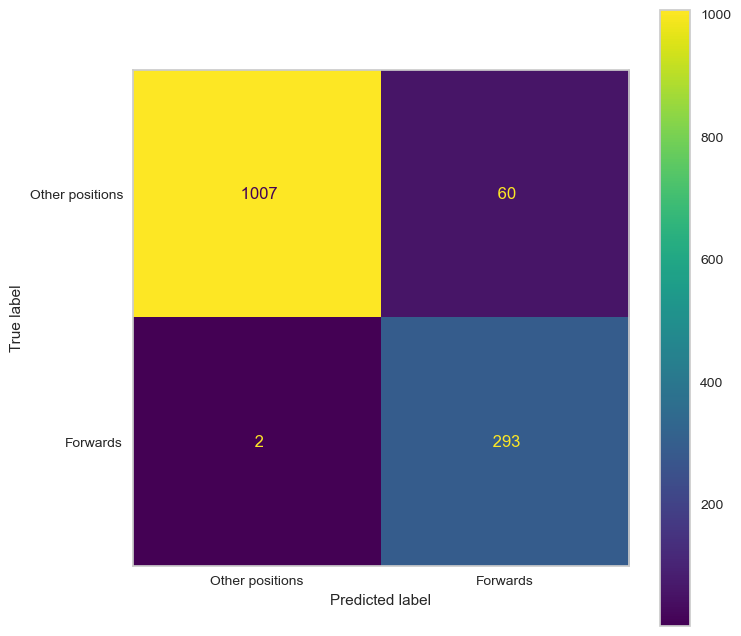

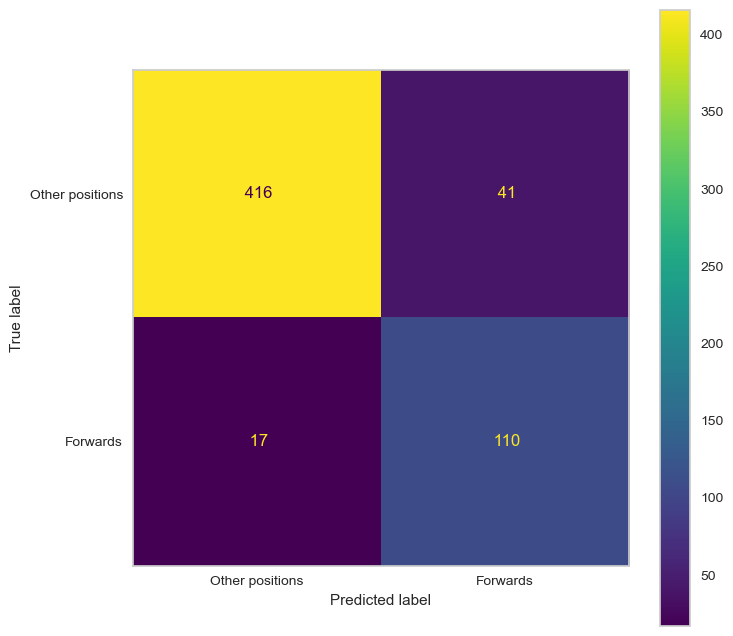

In [48]:
conf_matrix_show(bbc_model, X_train_sc, y_train, labels)
conf_matrix_show(bbc_model, X_test_sc, y_test, labels)

In [49]:
train_recall.append(recall_score(y_train, bbc_train_pred))
test_recall.append(recall_score(y_test, bbc_test_pred))
train_precision.append(precision_score(y_train, bbc_train_pred))
test_precision.append(precision_score(y_test, bbc_test_pred))
time_diffs.append(time_diff_bbc)

### AdaBoost Classifier + SMOTE.

AdaBoostClassifier również oparty jest na boostingu - przeprowadza wstępny trening klasyfikatora na oryginalnym zbiorze danych, a następnie trenuje dodatkowe "kopie" klasyfikatora, przypisując odpowiednie wagi do błędnie zaklasyfikowanych przykładów. W ten sposób model lepiej uczy się rozpoznawać przypadki sprawiające algorytmowi problemy. Dla tego algorytmu, jako nieprzystosowanego ze swojej natury do niezbalansowanych klas, zastosujemy oversampling klasy mniejszościowej.

Pierwszym krokiem będzie więc stworzenie instancji SMOTE, która stworzy dodatkowe próbki w zbiorze treningowym.

Oversampled X_train shape: (2134, 14).
Oversampled y_train shape: (2134,).


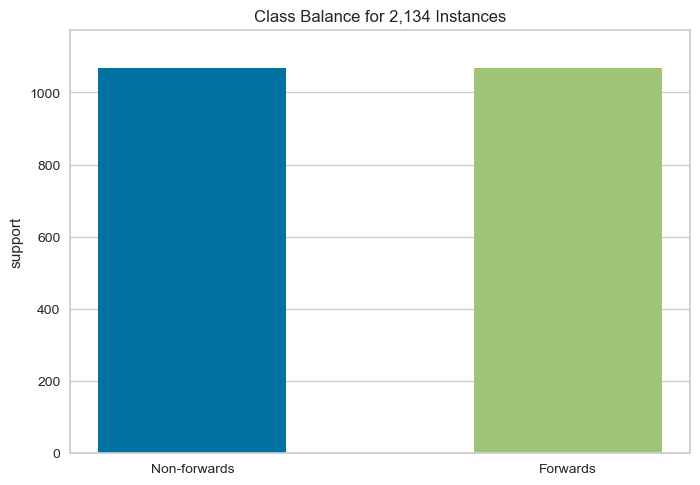

ClassBalance(ax=<AxesSubplot:title={'center':'Class Balance for 2,134 Instances'}, ylabel='support'>,
             labels=['Non-forwards', 'Forwards'])

In [50]:
oversampler = SMOTE()
X_over_sc, y_over = oversampler.fit_resample(X_train_sc, y_train)

print(f'Oversampled X_train shape: {X_over_sc.shape}.')
print(f'Oversampled y_train shape: {y_over.shape}.')
class_balance(y_over.flatten(), labels=['Non-forwards', 'Forwards'])

In [51]:
abc_model = AdaBoostClassifier()

start = time.time()
abc_model.fit(X_over_sc, y_over)
abc_train_pred = abc_model.predict(X_over_sc)
stop = time.time()
time_diff_abc = stop - start
print(f"Training time: {time_diff_abc} s.")

Training time: 0.2575969696044922 s.


Ze względu na sztuczne zbalansowanie zbioru treningowego metryki są intuicyjne i w gruncie rzeczy można je stosować zamiennie, jednak z tego też powodu nie można się nimi zbytnio sugerować. Wyniki odnośnie do klasy napastników są mocno przeciętne w porównaniu do pozostałych klasyfikatorów - czułość 0.89 przy precyzji 0.72 w klasie pozytywnej.

In [52]:
abc_test_pred = abc_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_over, abc_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, abc_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.97      0.94      0.95      1067
           1       0.94      0.97      0.95      1067

    accuracy                           0.95      2134
   macro avg       0.95      0.95      0.95      2134
weighted avg       0.95      0.95      0.95      2134

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.97      0.90      0.93       457
           1       0.72      0.89      0.79       127

    accuracy                           0.90       584
   macro avg       0.84      0.90      0.86       584
weighted avg       0.91      0.90      0.90       584



Plusem modelu jest to, iż jest dosyć precyzyjny, z drugiej strony czułość na próbki pozytywne jest wyraźnie niższa niż w przypadku Easy Ensemble i Balanced Random Forest.

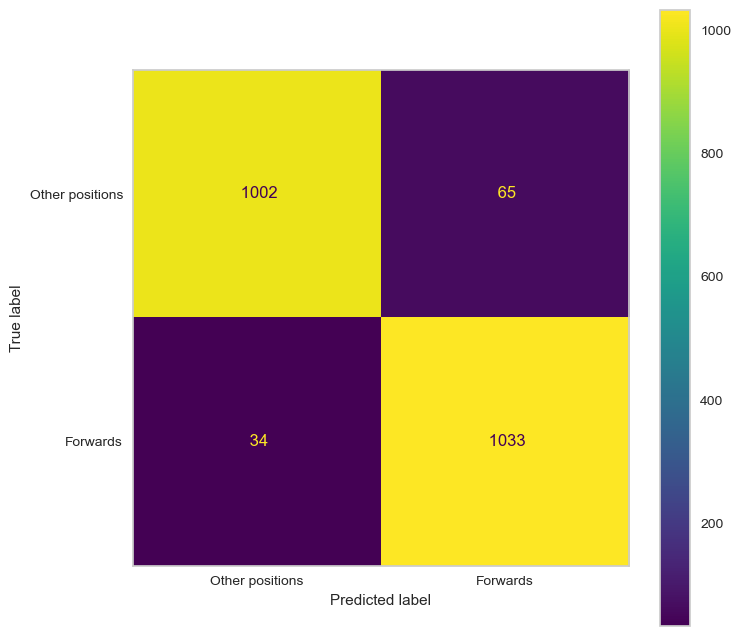

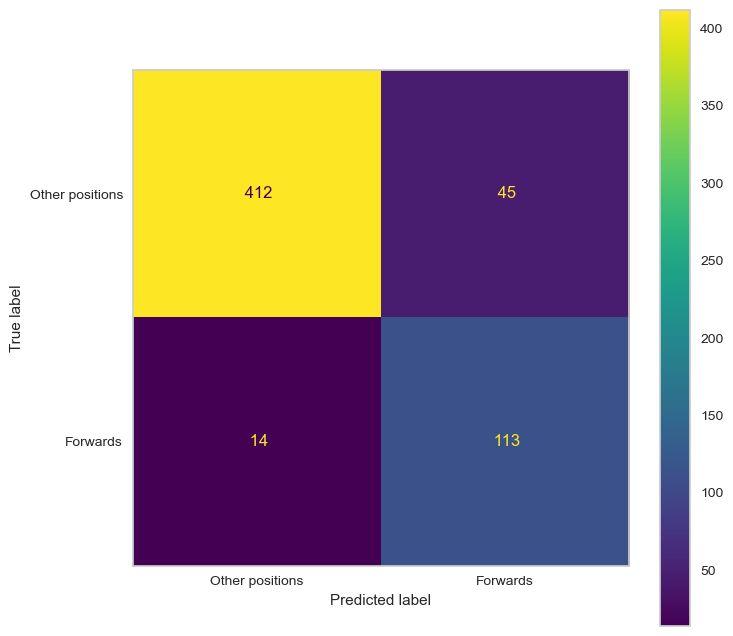

In [53]:
conf_matrix_show(abc_model, X_over_sc, y_over, labels)
conf_matrix_show(abc_model, X_test_sc, y_test, labels)

In [54]:
train_recall.append(recall_score(y_over, abc_train_pred))
test_recall.append(recall_score(y_test, abc_test_pred))
train_precision.append(precision_score(y_over, abc_train_pred))
test_precision.append(precision_score(y_test, abc_test_pred))
time_diffs.append(time_diff_abc)

### Random Forest Classifier + SMOTE.

Las losowy nieco szerzej opisałem na wstępie segmentu dot. Balanced Random Forest Classifiera. W poniższym przypadku zajmę się standardowym Random Forest Classifierem z zastosowaniem oversamplingu. 

In [55]:
rfc_model = RandomForestClassifier()

start = time.time()
rfc_model.fit(X_over_sc, y_over)
rfc_train_pred = rfc_model.predict(X_over_sc)
stop = time.time()
time_diff_rfc = stop - start
print(f"Training time: {time_diff_rfc} s.")

Training time: 0.4354565143585205 s.


Random Forest idealnie dopasował się do zbioru treningowego. Niestety, jest to jedyny tak mocno przeuczony klasyfikator. Metryki zbioru testowego notują bardzo wyraźny spadek, jeśli chodzi o wykrywanie napastników. Malutkim plusem jest najwyższa z porównywanych modeli precyzja.

In [56]:
rfc_test_pred = rfc_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_over, rfc_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rfc_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1067
           1       1.00      1.00      1.00      1067

    accuracy                           1.00      2134
   macro avg       1.00      1.00      1.00      2134
weighted avg       1.00      1.00      1.00      2134

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       457
           1       0.76      0.83      0.79       127

    accuracy                           0.91       584
   macro avg       0.85      0.88      0.87       584
weighted avg       0.91      0.91      0.91       584



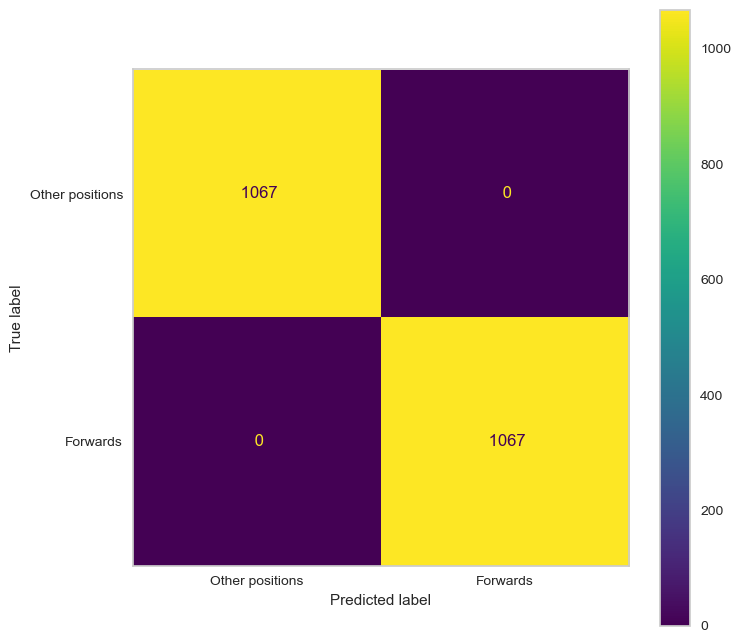

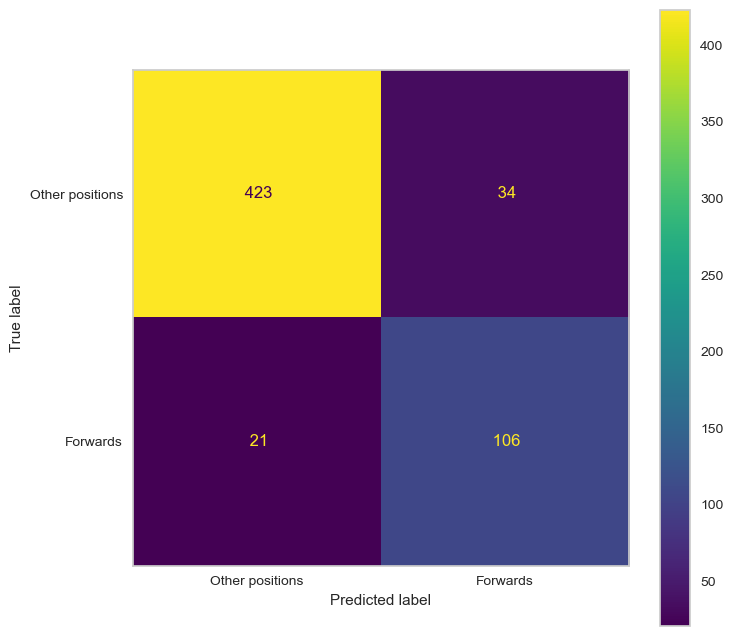

In [57]:
conf_matrix_show(rfc_model, X_over_sc, y_over, labels)
conf_matrix_show(rfc_model, X_test_sc, y_test, labels)

In [58]:
train_recall.append(recall_score(y_over, rfc_train_pred))
test_recall.append(recall_score(y_test, rfc_test_pred))
train_precision.append(precision_score(y_over, rfc_train_pred))
test_precision.append(precision_score(y_test, rfc_test_pred))
time_diffs.append(time_diff_rfc)

## Podsumowanie.

Zbiór danych, który wykorzystałem w tej części projektu, nie należy do największych, ale ma on swoje pułapki i przede wszystkim - swego rodzaju naturalnie występujący bias. Problemem w klasyfikacji napastników może być fakt, iż część z nich odnotowuje słabe statystyki - zdobywają mało goli, zaliczają niewiele asyst, rzadziej próbują dryblować. Da się to uzasadnić ich słabszymi umiejętnościami, grą w słabych zespołach, które nie tworzą im dogodnych sytuacji na stworzenie zagrożenia, względnie rolą na boisku - często nominalni napastnicy pełnią w istocie funkcję zawodnika, którego zadaniem jest absorbować na sobie obrońców, odgrywać piłkę do lepiej ustawionych partnerów. Są też sytuacje przeciwne - nominalni pomocnicy, a rzadziej obrońcy, notują tak dobre statystyki w ofensywie, że modele klasyfikują ich jako napastników. Są to jednak raczej wyjątki od ogólnej reguły, co znajduje potwierdzenie w wynikach uwidocznionych przez macierze pomyłek.

Kończąc tę część projektu, przyjrzyjmy się jeszcze metrykom poszczególnych modeli, aby zbiorczo porównać ich ogólne wyniki.

Wykorzystujemy w tym zbudowane wcześniej listy, które wcześniej konsekwentnie budowaliśmy, i na ich podstawie stwórzmy słowniki, które jako wartości przyjmą metryki czułości i precyzji oraz czas treningu, zaś jako klucze - wskazanie, których zbiorów dotyczą.

In [59]:
scores = {
          'Training recall': [i for i in train_recall],
          'Test recall': [i for i in test_recall],
          'Training precision': [i for i in train_precision],
          'Test precision': [i for i in test_precision],
          'Training time': [i for i in time_diffs]
}

Taka konstrukcja słowników pozwoli nam łatwo przekształcić je w kolumny ramki danych. Jako indeksy wskażemy nazwy poszczególnych klasyfikatorów, do których wyniki się odnoszą. Stworzymy także kolumny, która uwidocznią nam różnice między wynikami ze zbioru treningowego i testowego.

In [60]:
scores = pd.DataFrame(scores, index=['Balanced Random Forest', 'Easy Ensemble',
                                    'RUS Boost', 'Balanced Bagging', 'Ada Boost + SMOTE', 'Random Forest + SMOTE'])
scores['Recall difference'] = scores['Training recall'] - scores['Test recall']
scores['Precision difference'] = scores['Training precision'] - scores['Test precision']
(scores.style.highlight_max(color = 'lightgreen', axis = 0)
             .highlight_min(color = 'lightblue', axis = 0))

,Training recall,Test recall,Training precision,Test precision,Training time,Recall difference,Precision difference
Balanced Random Forest,1.000000,0.921260,0.762274,0.676301,0.598995,0.078740,0.085973
Easy Ensemble,0.986441,0.937008,0.748072,0.687861,1.902575,0.049433,0.060211
RUS Boost,0.918644,0.842520,0.783237,0.694805,0.175997,0.076124,0.088432
Balanced Bagging,0.993220,0.866142,0.830028,0.728477,0.066987,0.127079,0.101552
Ada Boost + SMOTE,0.968135,0.889764,0.940801,0.715190,0.257597,0.078371,0.225612
Random Forest + SMOTE,1.000000,0.834646,1.000000,0.757143,0.435457,0.165354,0.242857


Gdyby patrzeć na model przede wszystkim przez pryzmat czułości, za najlepsze należy uznać Easy Ensemble i Balanced RFC. Prezentują one wysoką skuteczność w wykrywaniu przypadków prawdziwie pozytywnych zarówno w przypadku zbioru treningowego, jak i testowego, i jako jedyne przekroczyły czułość 0.9. Balanced RFC ma jednak widoczną przewagę w postaci szybkości uczenia - jest ponad 3x szybszy niż Easy Ensemble, co przy konieczności dostrojenia i przeprowadzenia walidacji krzyżowej mogłoby spowodować znaczne przeciągnięcie się treningu. Na plus obu klasyfikatorów należy również odnotować względnie nieduży spadek metryk dla danych testowych.

Najsłabiej spisały się Balanced Bagging i Random Forest Classifier z wykorzystaniem SMOTE - okazały się mieć słabą zdolność generalizacyjną - o ile wyniki na zbiorze treningowym są najbliższe idealnemu dopasowaniu, o tyle podczas testowaniu metryki mocno spadają. Jedynym plusem Balanced Baggingu jest szybkość działania - był to wyraźnie najszybszy algorytm.

Dosyć ciekawym trade offem jest AdaBoost przy zastosowaniu oversamplingu - model ten naprawdę nieźle radzi sobie z wykrywaniem przypadków prawdziwie pozytywnych, jest przy tym szybki (a trzeba pamiętać, że musiał przyswoić znacznie więcej rekordów) i całkiem przyzwoicie jest w stanie uogólniać wyniki.

Pamiętać jednak musimy, że powyższe modele uczone były na instancjach niedostrojonych. Przeprowadzanie tuningu hiperparametrów i kroswalidacji (np. przy użyciu GridSearchCV) może pozwolić wycisnąć więcej z poszczególnych algorytmów i przyczynić się do wzrostu metryk.

# Klasyfikacja wieloklasowa.

Przechodzimy do klasyfikacji wieloklasowej. Tym razem nasze modele będą miały za zadanie przypisać wszystkich zawodników do każdej z pozycji - bramkarz, obrońca, pomocnik, napastnik. Przetestuję ponownie te same algorytmy, co w poprzedniej części, również z domyślnymi hiperparametrami.

Zaczynamy od wykorzystania LabelEncodera, który przekształci poszczególne kategorie typu string na etykiety numeryczne.

In [61]:
le = LabelEncoder()
y_l = le.fit_transform(Y)

In [62]:
le.classes_

array(['Attacker', 'Defender', 'Goalkeeper', 'Midfielder'], dtype=object)

In [63]:
np.unique(y_l)

array([0, 1, 2, 3])

Proporcje zbiorów treningowego i testowego zachowujemy takie, jak w przypadku pierwszej części projektu.

In [64]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y_l,
                                                    test_size = 0.3,
                                                    random_state = 42, stratify=y_l)

Ponownie standaryzujemy zbiory treningowy i testowy, dokonujemy również redukcji wymiarowości z użyciem tej samej liczby cech, co w klasyfikacji binarnej, a także oversamplingu przy użyciu SMOTE. Odwołujemy się w tym celu do już istniejących instancji ww. klas.

Oversampled X_train shape: (2020, 14).
Oversampled y_train shape: (2020,).


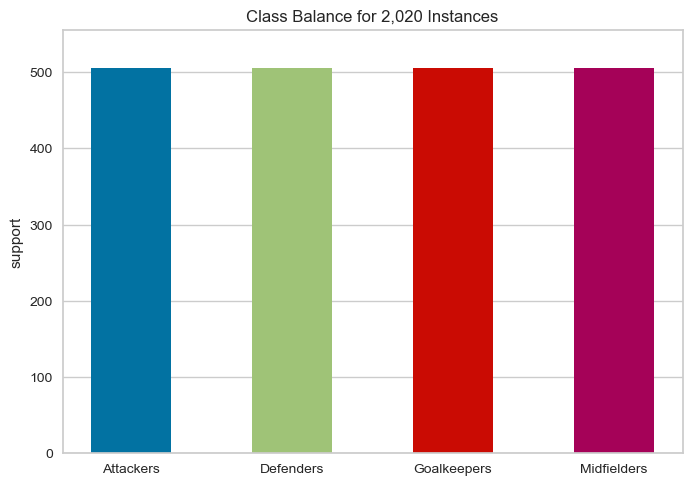

ClassBalance(ax=<AxesSubplot:title={'center':'Class Balance for 2,020 Instances'}, ylabel='support'>,
             labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

In [65]:
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

X_train_sc = pca.fit_transform(X_train_sc)
X_test_sc = pca.transform(X_test_sc)

X_res_sc, y_res = oversampler.fit_resample(X_train_sc, y_train)
print(f'Oversampled X_train shape: {X_res_sc.shape}.')
print(f'Oversampled y_train shape: {y_res.shape}.')

class_balance(y_res.flatten(), labels=['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders'])

## Balanced Random Forest Classifier.

In [66]:
brfc_model = BalancedRandomForestClassifier()

start = time.time()
brfc_model.fit(X_train_sc, y_train)
brfc_train_pred = brfc_model.predict(X_train_sc)
stop = time.time()
time_diff_brfc = stop - start
print(f"Training time: {time_diff_brfc} s.")

Training time: 0.4492359161376953 s.


Metryki dla obu zbiorów są znacznie słabsze niż przy klasyfikacji binarnej. Zarysował się wyraźny kłopot z klasyfikacją pomocników (klasa 3) przez algorytm. Do klasyfikacji bramkarzy (klasa 2) nie można mieć większych zarzutów - wyniki są bliskie 1.

In [67]:
brfc_test_pred = brfc_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, brfc_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, brfc_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.80      0.96      0.87       295
           1       0.86      0.88      0.87       505
           2       0.98      1.00      0.99        93
           3       0.83      0.71      0.77       469

    accuracy                           0.85      1362
   macro avg       0.87      0.89      0.87      1362
weighted avg       0.85      0.85      0.84      1362

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.71      0.93      0.81       127
           1       0.80      0.76      0.78       217
           2       0.91      1.00      0.95        39
           3       0.65      0.55      0.60       201

    accuracy                           0.74       584
   macro avg       0.77      0.81      0.78       584
weighted avg       0.74      0.74      0.73       584



Jak widać, pomocnicy bywają w znacznym stopniu myleni z obrońcami i napastnikami.

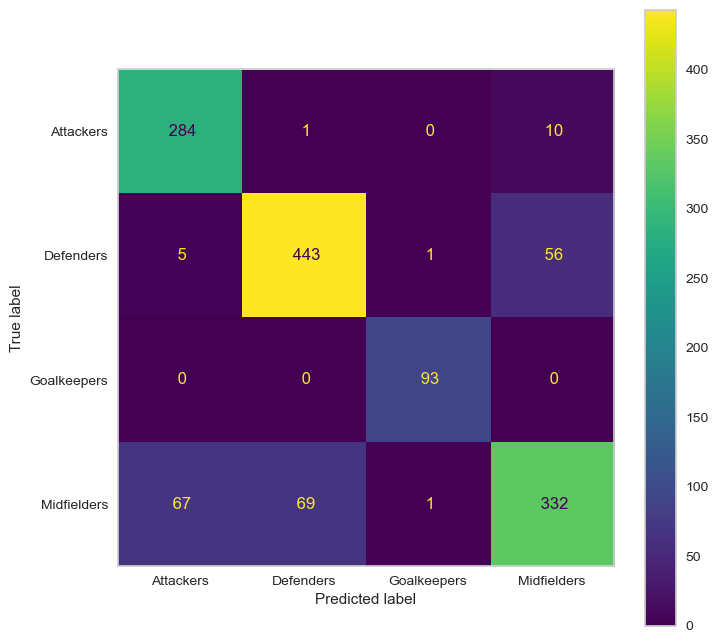

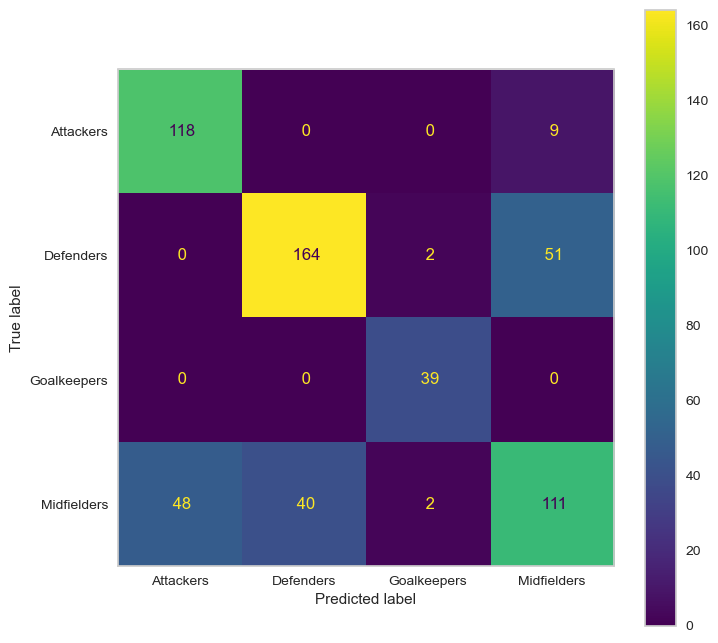

In [68]:
labels = ['Attackers', 'Defenders', 'Goalkeepers', 'Midfielders']

conf_matrix_show(brfc_model, X_train_sc, y_train, labels)
conf_matrix_show(brfc_model, X_test_sc, y_test, labels)

Kolejny raz tworzymy listy dla porównania wyników.

In [69]:
train_recall = []
test_recall = []
train_precision = []
test_precision = []
time_diffs = []
train_recall.append(recall_score(y_train, brfc_train_pred, average='weighted'))
test_recall.append(recall_score(y_test, brfc_test_pred, average='weighted'))
train_precision.append(precision_score(y_train, brfc_train_pred, average='weighted'))
test_precision.append(precision_score(y_test, brfc_test_pred, average='weighted'))
time_diffs.append(time_diff_brfc)

## Easy Ensemble Classifier.

In [70]:
eec_model = EasyEnsembleClassifier()

start = time.time()
eec_model.fit(X_train_sc, y_train)
eec_train_pred = eec_model.predict(X_train_sc)
stop = time.time()
time_diff_eec = stop - start
print(f"Training time: {time_diff_eec} s")

Training time: 1.15482759475708 s


Model ten okazał się być czulszy na pomocników (dla obu zbiorów czułość bliska 0.7), dalej jest konsekwentnie dokładny w wykrywaniu bramkarzy, za to kompletnie się gubi przy klasyfikowaniu napastników i obrońców, klasyfikując poprawnie bardzo małą część przypadków.

In [71]:
eec_test_pred = eec_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, eec_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, eec_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.27      0.20      0.23       295
           1       0.57      0.09      0.16       505
           2       0.95      1.00      0.97        93
           3       0.34      0.71      0.46       469

    accuracy                           0.39      1362
   macro avg       0.53      0.50      0.46      1362
weighted avg       0.45      0.39      0.34      1362

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.25      0.18      0.21       127
           1       0.61      0.11      0.18       217
           2       0.95      0.97      0.96        39
           3       0.34      0.70      0.45       201

    accuracy                           0.38       584
   macro avg       0.54      0.49      0.45       584
weighted avg       0.46      0.38      0.33       584



O ile Balanced RFC miał sporą tendencję do klasyfikowania pomocników jako obrońców lub napastników, o tyle Easy Ensemble potęguje ten problem.

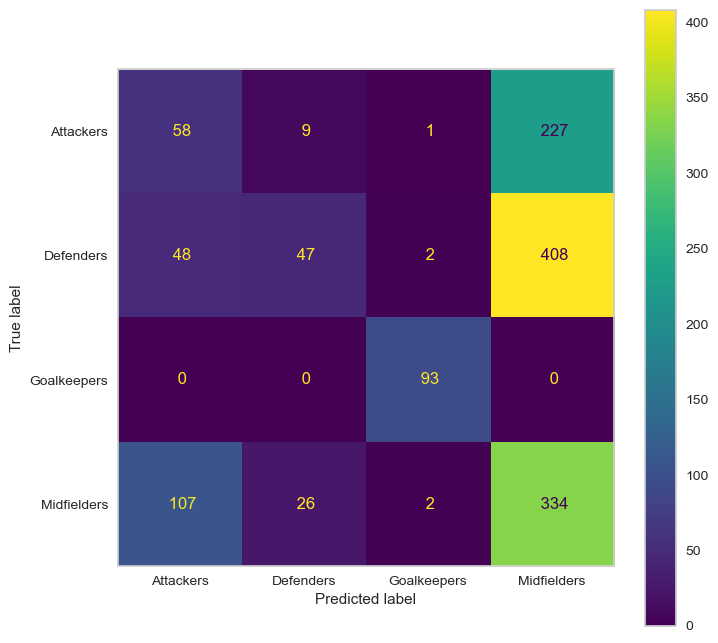

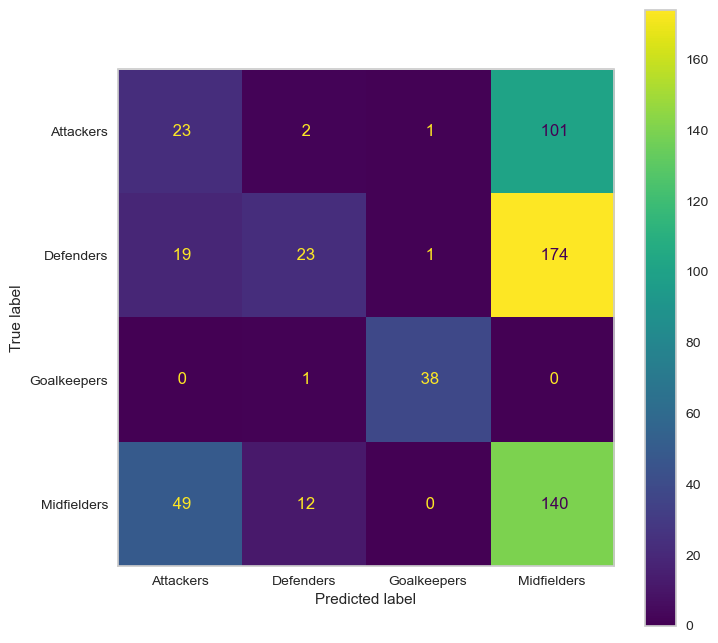

In [72]:
conf_matrix_show(eec_model, X_train_sc, y_train, labels)
conf_matrix_show(eec_model, X_test_sc, y_test, labels)

Macierze pomyłek uwidaczniają wszystkie bolączki tego modelu.

In [73]:
train_recall.append(recall_score(y_train, eec_train_pred, average='weighted'))
test_recall.append(recall_score(y_test, eec_test_pred, average='weighted'))
train_precision.append(precision_score(y_train, eec_train_pred, average='weighted'))
test_precision.append(precision_score(y_test, eec_test_pred, average='weighted'))
time_diffs.append(time_diff_eec)

## RUS Boost Classifier.

In [74]:
rusbc_model = RUSBoostClassifier()

start = time.time()
rusbc_model.fit(X_train_sc, y_train)
rusbc_train_pred = rusbc_model.predict(X_train_sc)
stop = time.time()
time_diff_rusbc = stop - start
print(f"Training time: {time_diff_rusbc} s")

Training time: 0.1828768253326416 s


Model ten wyróżnił się, ale in minus - tragicznie wygląda klasyfikacja pomocników (TP stanowią mniej niż 20% wszystkich przypadków!), zaczął się on wyraźnie mylić co do bramkarzy, a wydawać się to może najłatwiejsza do rozróżnienia klasa. 

In [75]:
rusbc_test_pred = rusbc_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, rusbc_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rusbc_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.62      0.86      0.72       295
           1       0.60      0.86      0.71       505
           2       1.00      0.88      0.94        93
           3       0.56      0.18      0.27       469

    accuracy                           0.63      1362
   macro avg       0.70      0.70      0.66      1362
weighted avg       0.62      0.63      0.58      1362

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.58      0.81      0.68       127
           1       0.62      0.85      0.71       217
           2       1.00      0.85      0.92        39
           3       0.46      0.17      0.25       201

    accuracy                           0.61       584
   macro avg       0.66      0.67      0.64       584
weighted avg       0.58      0.61      0.56       584



Trudno wskazać - może poza obrońcami - klasę, którą ten model przewiduje powyżej dotychczasowej przeciętnej.

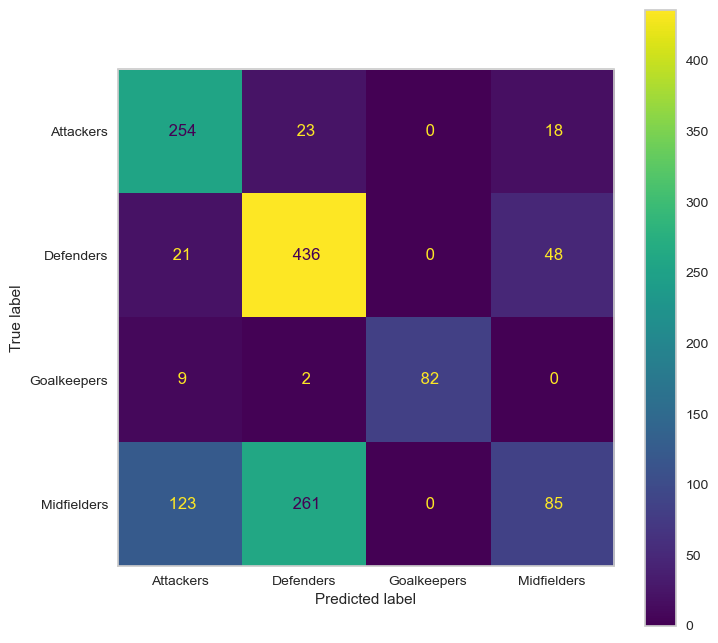

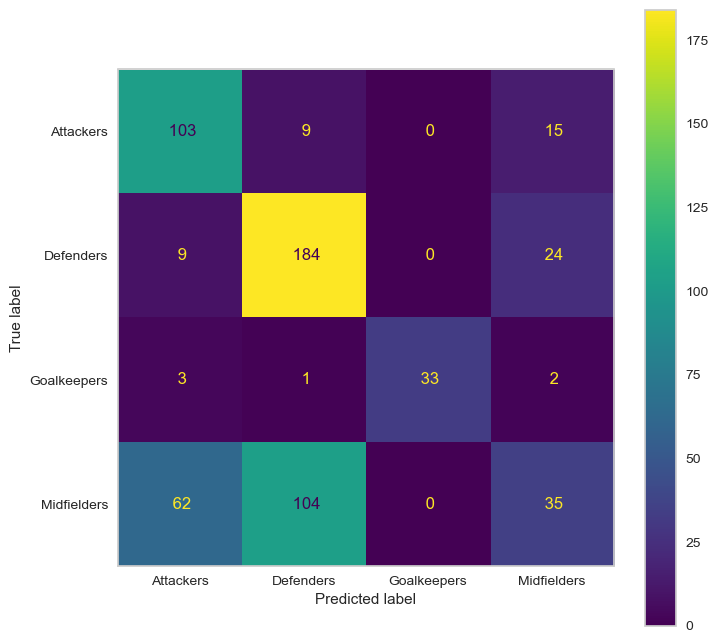

In [76]:
conf_matrix_show(rusbc_model, X_train_sc, y_train, labels)
conf_matrix_show(rusbc_model, X_test_sc, y_test, labels)

In [77]:
train_recall.append(recall_score(y_train, rusbc_train_pred, average='weighted'))
test_recall.append(recall_score(y_test, rusbc_test_pred, average='weighted'))
train_precision.append(precision_score(y_train, rusbc_train_pred, average='weighted'))
test_precision.append(precision_score(y_test, rusbc_test_pred, average='weighted'))
time_diffs.append(time_diff_rusbc)

## Balanced Bagging Classifier.

In [78]:
bbc_model = BalancedBaggingClassifier()

start = time.time()
bbc_model.fit(X_train_sc, y_train)
bbc_train_pred = bbc_model.predict(X_train_sc)
stop = time.time()
time_diff_bbc = stop - start
print(f"Training time: {time_diff_bbc} s")

Training time: 0.0776662826538086 s


Model ten mógłby być przyzwoitą alternatywą dla poprzedników, ale problem z nim ponownie przejawia się w słabych przewidywaniach co do pomocników i generalnie sporym przeuczeniu.

In [79]:
bbc_test_pred = bbc_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_train, bbc_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, bbc_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.78      0.93      0.85       295
           1       0.83      0.84      0.84       505
           2       0.94      1.00      0.97        93
           3       0.79      0.68      0.73       469

    accuracy                           0.81      1362
   macro avg       0.84      0.86      0.85      1362
weighted avg       0.81      0.81      0.81      1362

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.70      0.86      0.77       127
           1       0.73      0.73      0.73       217
           2       0.88      0.97      0.93        39
           3       0.58      0.49      0.53       201

    accuracy                           0.69       584
   macro avg       0.72      0.76      0.74       584
weighted avg       0.68      0.69      0.68       584



Gdyby nie problem z pomocnikami (choć nie największy, jak dotąd), można by było ten algorytm potraktować jako w miarę udany.

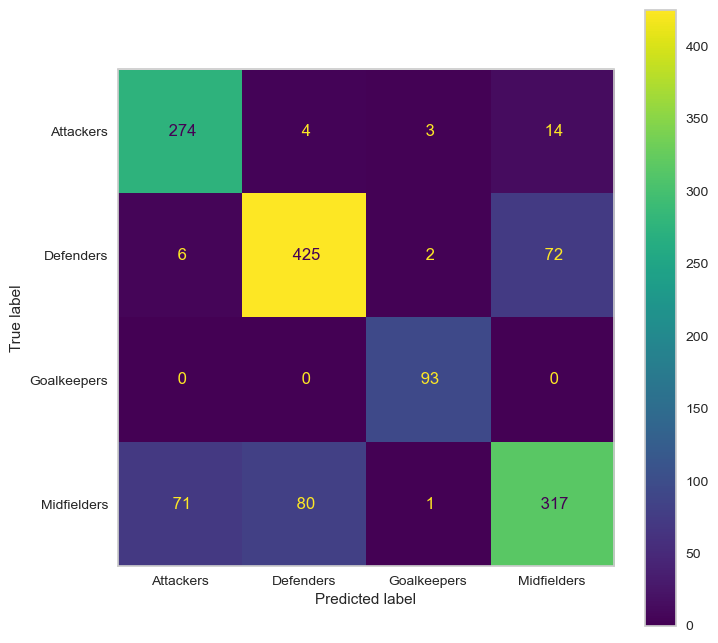

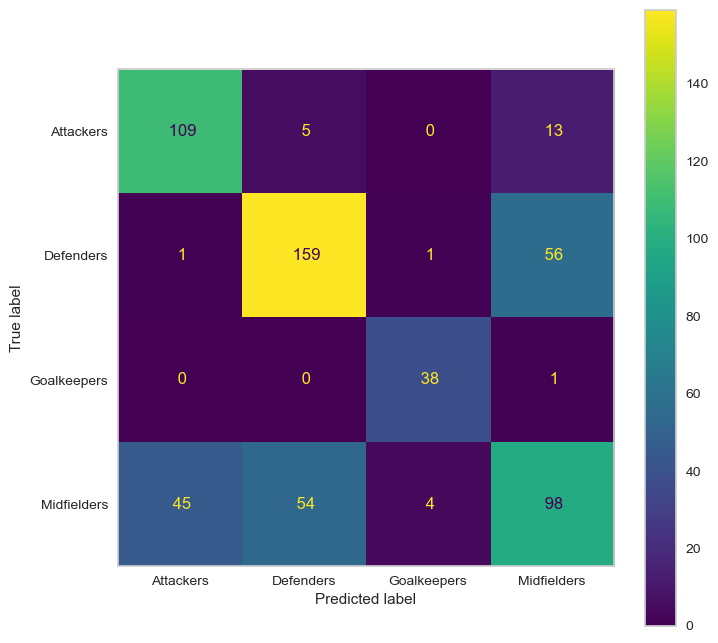

In [80]:
conf_matrix_show(bbc_model, X_train_sc, y_train, labels)
conf_matrix_show(bbc_model, X_test_sc, y_test, labels)

In [81]:
train_recall.append(recall_score(y_train, bbc_train_pred, average='weighted'))
test_recall.append(recall_score(y_test, bbc_test_pred, average='weighted'))
train_precision.append(precision_score(y_train, bbc_train_pred, average='weighted'))
test_precision.append(precision_score(y_test, bbc_test_pred, average='weighted'))
time_diffs.append(time_diff_bbc)

## AdaBoost Classifier + SMOTE.

In [82]:
abc_model = AdaBoostClassifier()

start = time.time()
abc_model.fit(X_res_sc, y_res)
abc_train_pred = abc_model.predict(X_res_sc)
stop = time.time()
time_diff_abc = stop - start
print(f"Training time: {time_diff_abc} s.")

Training time: 0.42893528938293457 s.


Model AdaBoost z użyciem SMOTE spisał się fatalnie. Jedynie z napastnikami poradził on sobie względnie dobrze (mimo słabej precyzji), ale przewidywania co do reszty klas są bardzo kiepskie - dość powiedzieć, że nie udało się temu algorytmowi wykryć prawie żadnego pomocnika!

In [83]:
abc_test_pred = abc_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_res, abc_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, abc_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       0.34      0.99      0.51       505
           1       0.19      0.06      0.09       505
           2       1.00      0.77      0.87       505
           3       0.67      0.00      0.01       505

    accuracy                           0.45      2020
   macro avg       0.55      0.45      0.37      2020
weighted avg       0.55      0.45      0.37      2020

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.24      0.98      0.39       127
           1       0.47      0.08      0.13       217
           2       1.00      0.77      0.87        39
           3       0.00      0.00      0.00       201

    accuracy                           0.29       584
   macro avg       0.43      0.46      0.35       584
weighted avg       0.29      0.29      0.19       584



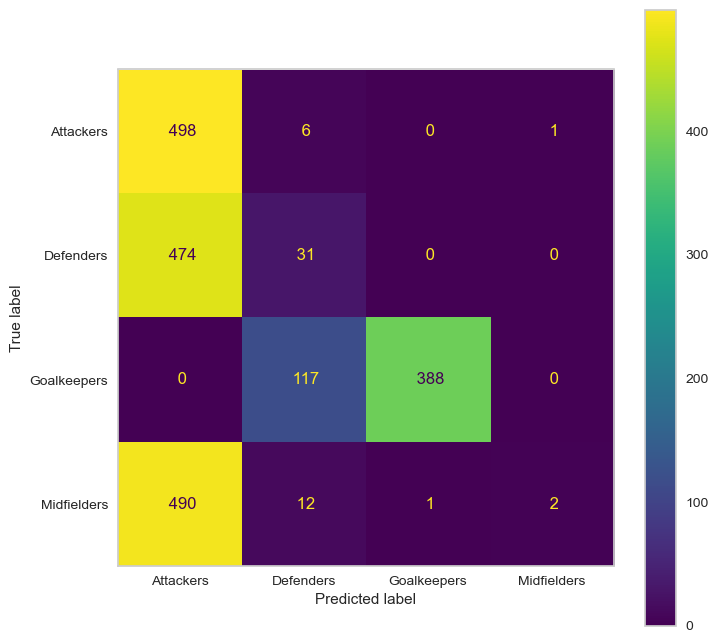

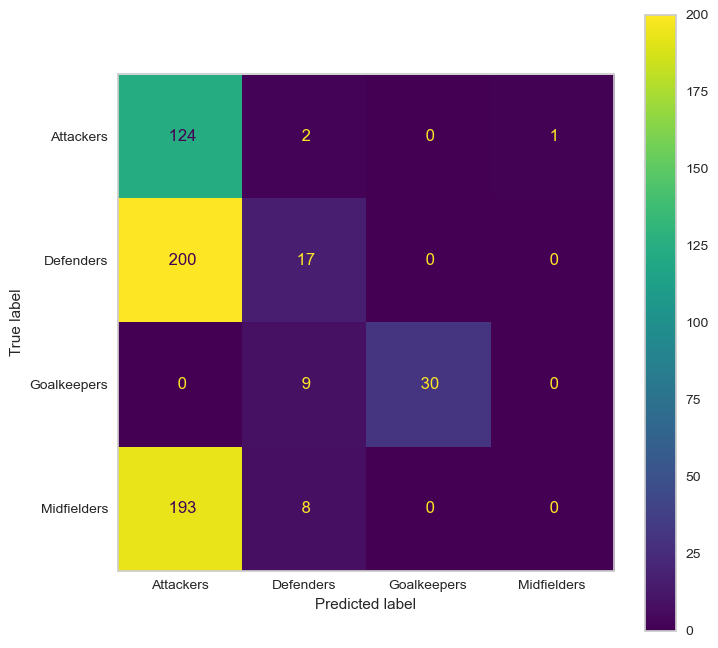

In [85]:
conf_matrix_show(abc_model, X_res_sc, y_res, labels)
conf_matrix_show(abc_model, X_test_sc, y_test, labels)

In [87]:
train_recall.append(recall_score(y_res, abc_train_pred, average='weighted'))
test_recall.append(recall_score(y_test, abc_test_pred, average='weighted'))
train_precision.append(precision_score(y_res, abc_train_pred, average='weighted'))
test_precision.append(precision_score(y_test, abc_test_pred, average='weighted'))
time_diffs.append(time_diff_abc)

## Random Forest Classifier + SMOTE.

In [88]:
rfc_model = RandomForestClassifier()

start = time.time()
rfc_model.fit(X_res_sc, y_res)
rfc_train_pred = rfc_model.predict(X_res_sc)
stop = time.time()
time_diff_rfc = stop - start
print(f"Training time: {time_diff_rfc} s.")

Training time: 0.730736494064331 s.


RFC idealnie dopasował się do zbioru treningowego, ale spadek metryk dla zbioru testowego jest bardzo duży. Mimo nie najlepszej zdolności do uogólniania ten model wypada jednak najlepiej w stosunku do zbioru testowego.

In [89]:
rfc_test_pred = rfc_model.predict(X_test_sc)
print(f'Training metrics:\n\n{classification_report(y_res, rfc_train_pred)}')
print('_____________________________________________________\n')
print(f'Test metrics:\n\n{classification_report(y_test, rfc_test_pred)}')

Training metrics:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       505
           1       1.00      1.00      1.00       505
           2       1.00      1.00      1.00       505
           3       1.00      1.00      1.00       505

    accuracy                           1.00      2020
   macro avg       1.00      1.00      1.00      2020
weighted avg       1.00      1.00      1.00      2020

_____________________________________________________

Test metrics:

              precision    recall  f1-score   support

           0       0.74      0.87      0.80       127
           1       0.81      0.77      0.79       217
           2       1.00      1.00      1.00        39
           3       0.66      0.62      0.64       201

    accuracy                           0.76       584
   macro avg       0.80      0.81      0.81       584
weighted avg       0.75      0.76      0.75       584



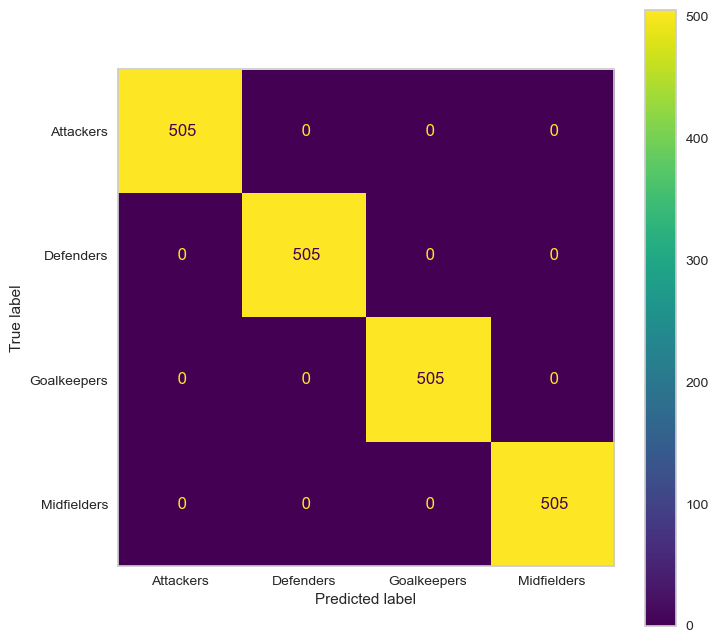

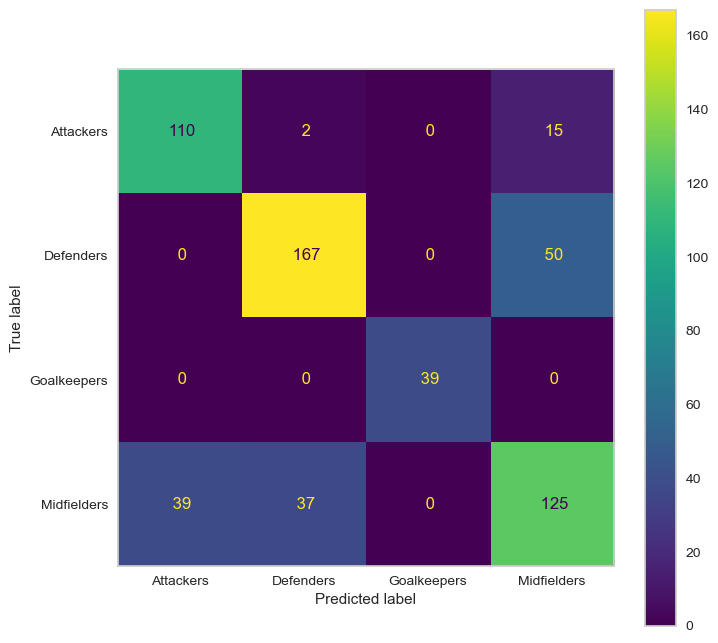

In [90]:
conf_matrix_show(rfc_model, X_res_sc, y_res, labels)
conf_matrix_show(rfc_model, X_test_sc, y_test, labels)

In [91]:
train_recall.append(recall_score(y_res, rfc_train_pred, average='weighted'))
test_recall.append(recall_score(y_test, rfc_test_pred, average='weighted'))
train_precision.append(precision_score(y_res, rfc_train_pred, average='weighted'))
test_precision.append(precision_score(y_test, rfc_test_pred, average='weighted'))
time_diffs.append(time_diff_rfc)

## Podsumowanie.

Ponownie zbieramy listy dot. wszystkich modeli i przekształcamy w ramkę danych.

In [92]:
scores = {
          'Training recall': [i for i in train_recall],
          'Test recall': [i for i in test_recall],
          'Training precision': [i for i in train_precision],
          'Test precision': [i for i in test_precision],
          'Training time': [i for i in time_diffs]
}

In [93]:
scores = pd.DataFrame(scores, index=['Balanced Random Forest', 'Easy Ensemble',
                                    'RUS Boost', 'Balanced Bagging', 'Ada Boost + SMOTE', 'Random Forest + SMOTE'])
scores['Recall difference'] = scores['Training recall'] - scores['Test recall']
scores['Precision difference'] = scores['Training precision'] - scores['Test precision']
(scores.style.highlight_max(color = 'lightgreen', axis = 0)
             .highlight_min(color = 'lightblue', axis = 0))

,Training recall,Test recall,Training precision,Test precision,Training time,Recall difference,Precision difference
Balanced Random Forest,0.845815,0.739726,0.847061,0.737284,0.449236,0.106089,0.109777
Easy Ensemble,0.390602,0.383562,0.454987,0.459415,1.154828,0.007040,-0.004428
RUS Boost,0.629222,0.607877,0.621195,0.581261,0.182877,0.021345,0.039935
Balanced Bagging,0.814244,0.691781,0.813674,0.683725,0.077666,0.122463,0.129949
Ada Boost + SMOTE,0.454950,0.292808,0.547868,0.294405,0.428935,0.162142,0.253463
Random Forest + SMOTE,1.000000,0.755137,1.000000,0.754988,0.730736,0.244863,0.245012


Klasyfikacja wieloklasowa poszła wyraźnie słabiej. Każdy z modeli borykał się z dużymi problemami; dość powiedzieć, że będące wcześniej jednymi z najlepszych modele oparte na Easy Ensemble i AdaBoost okazały się zwyczajnie niedouczonymi. Najlepiej z kolei wypadły modele baggingowe: RFC, Balanced RFC i Balanced Bagging. Te algorytmy miały jednak znaczny problem z klasyfikowaniem klasy 3 (pomocnicy), zmagały się przy tym z nie najlepszym uogólnianiem. Praktycznie każdy model nie miał większych problemów w klasyfikacji bramkarzy, ale jest pozycja na tyle specyficzna, że trudno ją pomylić z jakąkolwiek inną.
Ta część projektu w pewnym sensie odzwierciedla twierdzenie o "braku darmowych obiadów"; nie ma algorytmu, który byłby uniwersalny i rozwiązałby wszystkie zadania klasyfikacyjne w sposób optymalny, a przecież dla wszystkich algorytmów zastosowałem dokładnie te same procedury. Duże rezerwy można jednak dostrzec w zastosowaniu takich działań, jak dostrajanie modeli (często połączone z walidacją krzyżową), a przede wszystkim zapewnienie modelowi większej liczby danych uczących - zbiór, na którym operowaliśmy, nie należy wszaka do największych.